# 금융데이터베이스 Group 7 기말프로젝트

* 20249032	곽기은	klutzduck@kaist.ac.kr
* 20249124	김태훈	thk24@kaist.ac.kr
* 20249197	서승건	seanseo@kaist.ac.kr
* 20249366	장우석	expressj@kaist.ac.kr
* 20249402	조영민	youngmin.cho@kaist.ac.kr
* 20249459	홍성수	seongsu.hong@kaist.ac.kr

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import wbgapi as wb

from statsmodels.tsa.stattools import adfuller
from pandas.tseries.offsets import MonthEnd, YearEnd
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from pathlib import Path
from PublicDataReader import Ecos
from PublicDataReader import Fred

# https://ecos.bok.or.kr/api/#/DevGuide/DevSpeciflcation
# SSL 보안 장비 등으로 인해 SSL Verification Error가 발생할 경우에 대비해서 requests.get할 때 verify = False하고, warning을 무시하도록 설정한다.
# SSL Verification을 끈다.
import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
# 한국은행 API를 사용하기 위한 인증정보를 설정한다.
BOK_API_URL = 'https://ecos.bok.or.kr/api'
BOK_API_KEY = 'W2HQL3IHAD2LKU409JDH'

FRED_API_KEY = 'c91b752313c5c426691c24ffbde0246e'

apiEcos = Ecos(BOK_API_KEY)
apiFred = Fred(FRED_API_KEY)

## 환율 변화율을 예측하기

### IMF 이전 환율정책:

* IMF 외환위기 이전 한국은 '관리변동환율제'를 채택하고 있었습니다.
* 이 제도 하에서 정부는 환율의 일일 변동폭을 제한하고, 외환시장에 직접 개입하여 환율을 관리했습니다.


### IMF 이후 환율정책:

* 1997년 12월 IMF 구제금융을 받으면서 한국은 '자유변동환율제'로 전환했습니다.
* 이 제도에서는 원칙적으로 시장의 수요와 공급에 따라 환율이 결정됩니다.
* 정부의 직접적인 시장 개입은 크게 줄어들었습니다

### 아베노믹스 (2012년 ~ ) : 2012년 12월 26일

* 영향력: 매우 큼
* 지속기간: 장기적 (수년간 지속)
* 직접성: 엔화 환율에 직접적인 영향
* 의도성: 의도적인 엔화 약세 정책

### 아베노믹스는 일본 경제 회복을 위해 의도적으로 엔화 가치를 낮추는 정책을 포함했습니다. 
### 이로 인해 엔화 가치가 급격히 하락했고, 원/엔 환율에 지속적이고 큰 영향을 미쳤습니다.

## Convert to monthly observations
### End-of-month observation

In [3]:
df_xr = apiEcos.get_statistic_search(통계표코드="731Y001", 통계항목코드1="0000002", 주기="D", 검색시작일자="20121226", 검색종료일자="20240809")
df_xr = df_xr[['시점','값']]
df_xr.rename(columns = {'시점' : 'date', '값' : 'KRW/JPY'}, inplace=True)
df_xr['date'] = pd.to_datetime(df_xr['date'])
df_xr['KRW/JPY'] = df_xr['KRW/JPY'].astype(float)
df_xr = df_xr.set_index('date')
df_monthly = df_xr.resample('M').last()
df_monthly['ret'] = df_monthly['KRW/JPY'].pct_change() * 100
df_monthly = df_monthly.dropna()
df_monthly.head(3)

,KRW/JPY,ret
date,,
2013-01-31,1188.47,-4.731864
2013-02-28,1176.20,-1.032420
2013-03-31,1180.13,0.334127


In [4]:
X = df_monthly.iloc[:-1]['ret']
X = sm.add_constant(X)
Y = df_monthly.iloc[1:]['ret']

sm.OLS(Y, X.values).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                   0.03353
Date:                Tue, 13 Aug 2024   Prob (F-statistic):              0.855
Time:                        10:25:02   Log-Likelihood:                -319.94
No. Observations:                 139   AIC:                             643.9
Df Residuals:                     137   BIC:                             649.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1469      0.207     -0.709      0.480      -0.557       0.263
x1            -0.0156      0.085     -0.183      0.855      -0.183       0.152
==============================================================================
Omnibus:                        0.974   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.614   Jarque-Bera (JB):                0.908
Skew:                           0.196   Prob(JB):                        0.635
Kurtosis:                       2.940   Cond. No.                         2.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

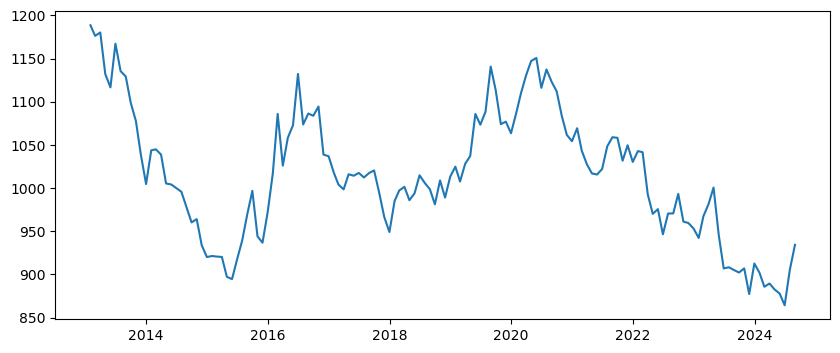

In [5]:
plt.rcParams['figure.figsize'] = (10, 4)
plt.plot(df_monthly['KRW/JPY'])
plt.show()

In [6]:
def load_world_bank_data(datacode, country, column):
    df = wb.data.DataFrame(datacode, numericTimeKeys=True)

    df = df.loc[country].to_frame()
    df = df.dropna()
    df[country] = df[country].astype(float)
    df['date'] = pd.to_datetime(df.index.astype(str)) + YearEnd()
    df = df.set_index('date')
    df.columns = [column]
    
    return df

In [7]:
# Price level ratio of PPP conversion factor (GDP) to market exchange rate - KOREA
df_real_xr_kor = load_world_bank_data('PA.NUS.PPPC.RF', 'KOR', 'KOR Real XR')
df_real_xr_kor.head(3)

,KOR Real XR
date,
1990-12-31,0.791111
1991-12-31,0.806041
1992-12-31,0.797916


In [8]:
# Price level ratio of PPP conversion factor (GDP) to market exchange rate - JAPAN
df_real_xr_jpn = load_world_bank_data('PA.NUS.PPPC.RF', 'JPN', 'JPN Real XR')
df_real_xr_jpn.head(3)

,JPN Real XR
date,
1990-12-31,1.295738
1991-12-31,1.386324
1992-12-31,1.465824


In [9]:
# 기존의 KOR와 JPN 데이터프레임을 합칩니다
df_combined = pd.concat([df_real_xr_kor, df_real_xr_jpn], axis=1)

# KRW/JPY 실질환율 계산
# KRW/USD를 JPY/USD로 나눈다
df_combined['KRW/JPY Real XR'] = df_combined['KOR Real XR'] / (df_combined['JPN Real XR'])

In [10]:
df_real_xr = df_combined['KRW/JPY Real XR']

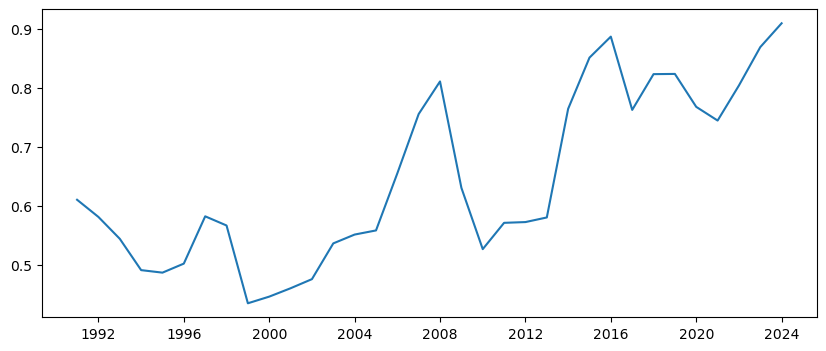

In [11]:
plt.plot(df_real_xr)
plt.show()

## Overlapping monthly forecasts

In [12]:
df_monthly = df_monthly.drop('ret', axis = 1)
df_merged = df_monthly.join(df_real_xr)
df_merged.loc['2013-01-31', 'KRW/JPY Real XR'] = 0.580543
df_merged['KRW/JPY Real XR'] = df_merged['KRW/JPY Real XR'].ffill()
df_merged['ann_ret'] = df_merged['KRW/JPY'].pct_change(periods = 12) * 100
df_merged['F12.ann_ret'] = df_merged['ann_ret'].shift(-12)

df_merged.head(15)


,KRW/JPY,KRW/JPY Real XR,ann_ret,F12.ann_ret
date,,,,
2013-01-31,1188.47,0.580543,NaN,-12.180366
2013-02-28,1176.20,0.580543,NaN,-11.169869
2013-03-31,1180.13,0.580543,NaN,-11.981731
2013-04-30,1132.04,0.580543,NaN,-11.194834
2013-05-31,1116.58,0.580543,NaN,-10.066453
2013-06-30,1167.15,0.580543,NaN,-14.321210
2013-07-31,1135.40,0.580543,NaN,-12.302272
2013-08-31,1129.19,0.580543,NaN,-13.426438
2013-09-30,1098.67,0.580543,NaN,-12.599780


### Use OLS to fit the forecast model

In [13]:
df = df_merged[['KRW/JPY Real XR', 'F12.ann_ret']]
df = df.dropna()

In [14]:
X = df['KRW/JPY Real XR']
X = sm.add_constant(X)
Y = df['F12.ann_ret']

sm.OLS(Y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            F12.ann_ret   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     37.45
Date:                Tue, 13 Aug 2024   Prob (F-statistic):           1.10e-08
Time:                        10:25:43   Log-Likelihood:                -433.05
No. Observations:                 128   AIC:                             870.1
Df Residuals:                     126   BIC:                             875.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -41.1914      6.477     -6.360      0.000     -54.009     -28.374
KRW/JPY Real XR    50.0005      8.171      6.119      0.000      33.830      66.171
==============================================================================
Omnibus:                        5.608   Durbin-Watson:                   0.228
Prob(Omnibus):                  0.061   Jarque-Bera (JB):                5.396
Skew:                           0.502   Prob(JB):                       0.0673
Kurtosis:                       3.070   Cond. No.                         20.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Real XR 대신 PPP XR 활용하기

In [15]:
# PPP conversion factor, GDP
df_ppp_xr_kor = load_world_bank_data('PA.NUS.PPP', 'KOR', 'PPP XR')
df_ppp_xr_jpn = load_world_bank_data('PA.NUS.PPP', 'JPN', 'PPP XR')

In [16]:
df_ppp_combined = pd.concat([df_ppp_xr_kor, df_ppp_xr_jpn], axis = 1)
df_ppp_combined.columns = ['KOR PPP XR', 'JPN PPP XR']
df_ppp_combined['KRW/JPY PPP XR'] = df_ppp_combined['KOR PPP XR'] / (df_ppp_combined['JPN PPP XR'])
df_ppp_xr = df_ppp_combined.drop(['KOR PPP XR', 'JPN PPP XR'], axis = 1)

In [17]:
df_ppp_xr.head(3)

,KRW/JPY PPP XR
date,
1990-12-31,2.984441
1991-12-31,3.165311
1992-12-31,3.355232


### Merge with monthly observations

In [18]:
df_merged = df_monthly.join(df_real_xr)
df_merged = df_merged.join(df_ppp_xr)
df_merged.head(3)

,KRW/JPY,KRW/JPY Real XR,KRW/JPY PPP XR
date,,,
2013-01-31,1188.47,NaN,NaN
2013-02-28,1176.20,NaN,NaN
2013-03-31,1180.13,NaN,NaN


### Compute Real XR

In [19]:
df_merged['KRW/JPY PPP XR'] = df_merged['KRW/JPY PPP XR'].ffill()
df_merged.head(3)

,KRW/JPY,KRW/JPY Real XR,KRW/JPY PPP XR
date,,,
2013-01-31,1188.47,NaN,NaN
2013-02-28,1176.20,NaN,NaN
2013-03-31,1180.13,NaN,NaN


In [20]:
df_merged

,KRW/JPY,KRW/JPY Real XR,KRW/JPY PPP XR
date,,,
2013-01-31,1188.47,NaN,NaN
2013-02-28,1176.20,NaN,NaN
2013-03-31,1180.13,NaN,NaN
2013-04-30,1132.04,NaN,NaN
2013-05-31,1116.58,NaN,NaN
...,...,...,...
2024-04-30,882.68,NaN,8.453422
2024-05-31,877.84,NaN,8.453422
2024-06-30,864.31,NaN,8.453422


In [21]:
df_merged['New Real XR'] = df_merged['KRW/JPY PPP XR'] / df_merged['KRW/JPY'] * 100
df_merged.tail(3)

,KRW/JPY,KRW/JPY Real XR,KRW/JPY PPP XR,New Real XR
date,,,,
2024-06-30,864.31,NaN,8.453422,0.978054
2024-07-31,905.44,NaN,8.453422,0.933626
2024-08-31,934.32,NaN,8.453422,0.904767


In [22]:
df_merged['KRW/JPY Real XR'] = df_merged['KRW/JPY Real XR'].ffill()

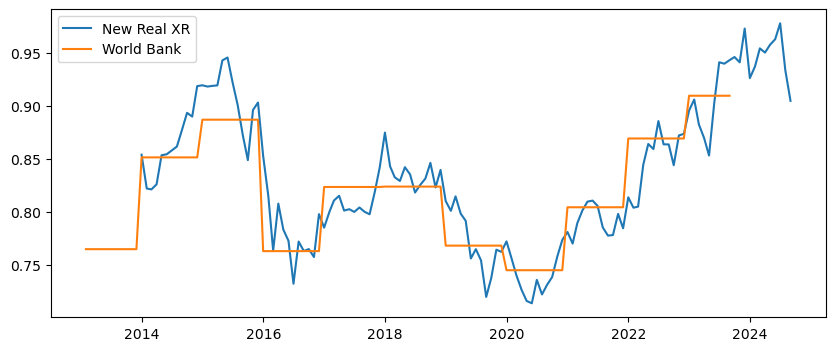

In [23]:
plt.plot(df_merged['New Real XR'], label='New Real XR')
plt.plot(df_merged['KRW/JPY Real XR'].shift(-12), label='World Bank')
plt.legend()
plt.show()

## Compute annual XR returns

In [24]:
df_merged['ann_ret'] = df_merged['KRW/JPY'].pct_change(periods = 12) * 100
df_merged['F12.ann_ret'] = df_merged['ann_ret'].shift(-12)
df_merged.head(5)

,KRW/JPY,KRW/JPY Real XR,KRW/JPY PPP XR,New Real XR,ann_ret,F12.ann_ret
date,,,,,,
2013-01-31,1188.47,NaN,NaN,NaN,NaN,-12.180366
2013-02-28,1176.20,NaN,NaN,NaN,NaN,-11.169869
2013-03-31,1180.13,NaN,NaN,NaN,NaN,-11.981731
2013-04-30,1132.04,NaN,NaN,NaN,NaN,-11.194834
2013-05-31,1116.58,NaN,NaN,NaN,NaN,-10.066453


### Use OLS to fit the forecast model

In [25]:
df = df_merged[['New Real XR', 'F12.ann_ret']]
df = df.dropna()

X = df['New Real XR']
X = sm.add_constant(X)
Y = df['F12.ann_ret']

results = sm.OLS(Y,X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            F12.ann_ret   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     26.27
Date:                Tue, 13 Aug 2024   Prob (F-statistic):           1.21e-06
Time:                        10:26:16   Log-Likelihood:                -395.03
No. Observations:                 117   AIC:                             794.1
Df Residuals:                     115   BIC:                             799.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -48.9105      9.410     -5.198      0.000     -67.549     -30.272
New Real XR    58.4435     11.404      5.125      0.000      35.855      81.032
==============================================================================
Omnibus:                        4.450   Durbin-Watson:                   0.156
Prob(Omnibus):                  0.108   Jarque-Bera (JB):                3.372
Skew:                           0.286   Prob(JB):                        0.185
Kurtosis:                       2.396   Cond. No.                         29.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Predict XR

In [26]:
last_obs = df_merged.iloc[-1]
last_obs

KRW/JPY            934.320000
KRW/JPY Real XR      0.909600
KRW/JPY PPP XR       8.453422
New Real XR          0.904767
ann_ret              3.231794
F12.ann_ret               NaN
Name: 2024-08-31 00:00:00, dtype: float64

In [27]:
last_xr = last_obs['KRW/JPY']
last_real_xr = last_obs['New Real XR']

In [28]:
last_xr

934.32

In [29]:
last_real_xr

0.9047673662483775

### OLS 결과 그대로 사용하여 예측

In [30]:
#exogeneous variables
exog = [1, last_real_xr]
results.predict(exog = exog)

array([3.96732709])

### Confidence Interval

In [31]:
for alpha in [0.05, 0.25, 0.50]:
    prstd, iv_l, iv_u = wls_prediction_std(results, exog = exog, alpha = alpha)
    
    print('Confidence interval at alpha = {:.2f}: {:.2f} ~ {:.2f}'.format(
        alpha,
        iv_l[0],
        iv_u[0],
    ))

Confidence interval at alpha = 0.05: -10.36 ~ 18.29
Confidence interval at alpha = 0.25: -4.39 ~ 12.33
Confidence interval at alpha = 0.50: -0.93 ~ 8.86


### 환율 예측하기

In [32]:
pred_ret = results.predict(exog = exog)
last_xr * (1 + pred_ret[0] / 100)

971.3875305012108

In [33]:
for alpha in [0.05, 0.25, 0.50]:
    prstd, iv_l, iv_u = wls_prediction_std(results, exog = exog, alpha = alpha)
    
    print('Confidence interval at alpha = {:.2f}: {:.2f} ~ {:.2f}'.format(
        alpha,
        last_xr * (1 + iv_l[0] / 100),
        last_xr * (1 + iv_u[0] / 100),
    ))

Confidence interval at alpha = 0.05: 837.54 ~ 1105.24
Confidence interval at alpha = 0.25: 893.26 ~ 1049.52
Confidence interval at alpha = 0.50: 925.66 ~ 1017.11


## 추가 지표 획득

In [34]:
def fetch_bok_data(service_code, stat_code=None, item=None):
    url = f"{BOK_API_URL}/{service_code}/{BOK_API_KEY}/json/kr/1/100000"
    
    if item is not None:
        url += "/{}/{}/{}/{}/{}".format(item['STAT_CODE'], item['CYCLE'], item['START_TIME'], item['END_TIME'], item['ITEM_CODE'])
        
        if type(item['ITEM_CODE2']) is str:
            url += f"/{item['ITEM_CODE2']}"
        
    elif stat_code is not None:
        url += f"/{stat_code}"
    
    print(url)
    
    resp = requests.get(url, verify = False)
    results = resp.json()
    rows = results[service_code]['row']
    df = pd.DataFrame(rows)
    
    return df

In [35]:
TARGET_STAT_CODES = [
    '731Y001',  # 3.1.1.1. 주요국 통화의 대원화환율
    '902Y008',  # 9.1.2.2. 국제 주요국 소비자물가지수
    '902Y009',  # 9.1.3.1. 국제 주요국 경상수지
    '902Y015',  # 9.1.4.1. 국제 주요국 경제성장률
    '902Y016',  # 9.1.4.2. 국제 주요국 국내총생산(GDP)
    '902Y023',  # 9.1.6.1. 주요국제금리
    '817Y002',  # 1.3.2.1. 시장금리(일별)
    '732Y001',  # 3.5. 외환보유액
]

In [36]:
dfs = []

for stat_code in TARGET_STAT_CODES:
    df = fetch_bok_data('StatisticItemList', stat_code = stat_code)
    
    dfs.append(df)

https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/731Y001
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y008
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y009
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y015
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y016
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y023
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/817Y002
https://ecos.bok.or.kr/api/StatisticItemList/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/732Y001


In [37]:
df_item_codes = pd.concat(dfs, axis = 0)

In [38]:
df_item_codes.to_excel(Path('data/bok_item_codes.xlsx'), index = False)

In [39]:
df_item_codes = df_item_codes.set_index(['STAT_CODE', 'ITEM_CODE', 'CYCLE'])

### Download data values

In [40]:
data_download_list = pd.read_excel(Path('data/bok_data_download_list_jpy.xlsx'))

In [41]:
data_download_list

,name,STAT_CODE,STAT_NAME,ITEM_CODE,ITEM_CODE2,ITEM_NAME,CYCLE,UNIT_NAME
0,krw_100jpy_xr,731Y001,3.1.1.1. 주요국 통화의 대원화환율,0000002,NaN,원/일본엔(100엔),D,원
1,cpi_korea,902Y008,9.1.2.2. 국제 주요국 소비자물가지수,KR,NaN,한국,M,2010=100
2,cpi_jp,902Y008,9.1.2.2. 국제 주요국 소비자물가지수,JP,NaN,일본,M,2010=100
3,cpi_us,902Y008,9.1.2.2. 국제 주요국 소비자물가지수,US,NaN,미국,M,2010=100
4,current_account_korea,902Y009,9.1.3.1. 국제 주요국 경상수지,KR,NaN,한국,Q,백만달러
5,current_account_jp,902Y009,9.1.3.1. 국제 주요국 경상수지,JP,NaN,일본,Q,백만달러
6,current_account_us,902Y009,9.1.3.1. 국제 주요국 경상수지,US,NaN,미국,Q,백만달러
7,gdp_growth_korea,902Y015,9.1.4.1. 국제 주요국 경제성장률,KOR,NaN,한국,Q,%
8,gdp_growth_jp,902Y015,9.1.4.1. 국제 주요국 경제성장률,JPN,NaN,일본,Q,%
9,gdp_growth_us,902Y015,9.1.4.1. 국제 주요국 경제성장률,USA,NaN,미국,Q,%


In [42]:
#iterate over row
for idx, row in data_download_list.iterrows():
    name = row['name']
    print(f"Downloading {name}...")
    
    idx = (row.STAT_CODE, row.ITEM_CODE, row.CYCLE)
    item = df_item_codes.loc[idx]
    item ={**item, **row}
    
    df = fetch_bok_data('StatisticSearch', item = item)
    df = df[['TIME', 'DATA_VALUE']]
    
    if row['CYCLE'] == 'D':
        df['date'] = pd.to_datetime(df['TIME'])
    
    elif row['CYCLE'] == 'M':
        df['date'] = pd.to_datetime(df['TIME'], format = '%Y%m') + MonthEnd()
    
    elif row['CYCLE'] == 'Q':
        df['year'] = df['TIME'].str[:4]
        df['month'] = df['TIME'].str[-1].astype(int) * 3
        df['day'] = 1
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']]) + MonthEnd()
    
    elif row['CYCLE'] == 'A':
        df['date'] = pd.to_datetime(df['TIME']) + YearEnd()
    
    else:
        raise RuntimeError()
        
    df = df[['date','DATA_VALUE']]
    df = df.rename(columns={'DATA_VALUE': name, })
    
    df[name] = df[name].astype(float)
    
    df.to_excel(Path(f"data/{name}.xlsx"), index = False)
    
print('** Completed!! **')

https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/731Y001/D/19770401/20240813/0000002
https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y008/M/195108/202406/KR
https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y008/M/195501/202406/JP
https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y008/M/195501/202406/US
https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y009/Q/1976Q1/2024Q1/KR
https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y009/Q/1996Q1/2024Q1/JP
https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y009/Q/1973Q1/2024Q1/US
https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y015/Q/1960Q2/2024Q2/KOR
https://ecos.bok.or.kr/api/StatisticSearch/W2HQL3IHAD2LKU409JDH/json/kr/1/100000/902Y015/Q/1960Q2/2024Q1/JPN
https://ecos.bok.

## BOK 파일 불러오기

In [43]:
filenames = [
    'krw_100jpy_xr',
    'current_account_korea',
    'current_account_us',
    'current_account_jp',
    'gdp_korea',
    'gdp_us',
    'gdp_jp',
    'gdp_growth_korea',
    'gdp_growth_jp',
    'gdp_growth_us',
    'cpi_korea',
    'cpi_jp',
    'cpi_us',
    'int_rate_korea',
    'int_rate_jp',
    'int_rate_us',
    'foreign_reserves',
]

In [44]:
dfs = []

for fname in filenames:
    print(f"Loding {fname}....")
    
    df = pd.read_excel(Path(f"data/{fname}.xlsx"))
    df = df.set_index('date')
    
    if fname in ['gdp_growth_korea',
        'gdp_growth_jp',
        'gdp_growth_us',
        'current_account_us',
        'current_account_jp',
        'current_account_korea',
                ]:
        df[fname] = df[fname].rolling(4).sum()
    
    dfs.append(df)
    
print('** Completed **')

Loding krw_100jpy_xr....
Loding current_account_korea....
Loding current_account_us....
Loding current_account_jp....
Loding gdp_korea....
Loding gdp_us....
Loding gdp_jp....
Loding gdp_growth_korea....
Loding gdp_growth_jp....
Loding gdp_growth_us....
Loding cpi_korea....
Loding cpi_jp....
Loding cpi_us....
Loding int_rate_korea....
Loding int_rate_jp....
Loding int_rate_us....
Loding foreign_reserves....
** Completed **


### World Bank 데이터로 계산했었던 KOR/JPY PPP XR 불러오기

In [45]:
dfs.append(df_ppp_xr)

## Merge the datasets

In [46]:
df_merged = pd.concat(dfs, axis = 1)
df_merged = df_merged.resample('M').last()
df_merged = df_merged.ffill()
df_merged.loc['2010-01-01':].head()

,krw_100jpy_xr,current_account_korea,current_account_us,current_account_jp,gdp_korea,gdp_us,gdp_jp,gdp_growth_korea,gdp_growth_jp,gdp_growth_us,cpi_korea,cpi_jp,cpi_us,int_rate_korea,int_rate_jp,int_rate_us,foreign_reserves,KRW/JPY PPP XR
date,,,,,,,,,,,,,,,,,,
2010-01-31,1287.00,33087.6,-379736.0,145677.71,943708.5,14478067.0,5289493.7,5.399,-1.661,0.118,98.82,100.09,99.37,2.88,0.20,0.45,273693584.0,7.189963
2010-02-28,1299.31,33087.6,-379736.0,145677.71,943708.5,14478067.0,5289493.7,5.399,-1.661,0.118,99.02,100.09,99.40,2.88,0.19,0.44,270659721.0,7.189963
2010-03-31,1217.68,20931.1,-382885.0,181383.81,943708.5,14478067.0,5289493.7,7.478,4.205,1.738,99.22,100.30,99.81,2.83,0.23,0.43,272331061.0,7.189963
2010-04-30,1186.77,20931.1,-382885.0,181383.81,943708.5,14478067.0,5289493.7,7.478,4.205,1.738,99.62,100.30,99.98,2.51,0.30,0.40,278873477.0,7.189963
2010-05-31,1318.54,20931.1,-382885.0,181383.81,943708.5,14478067.0,5289493.7,7.478,4.205,1.738,99.72,100.30,100.06,2.45,0.45,0.39,270221038.0,7.189963


In [47]:
df_merged_ssg = df_merged.copy()

# >>반영할 수 있는 지표들

### 환율 수익률

In [48]:
df_merged['ann_ret'] = df_merged['krw_100jpy_xr'].pct_change(periods = 12) * 100
df_merged['F12.ann_ret'] = df_merged['ann_ret'].shift(-12)

### Real XR

In [49]:
df_merged['real_xr'] = df_merged['KRW/JPY PPP XR'] / df_merged['krw_100jpy_xr'] * 100

### Current accounts(경상수지) relative to GDP

In [50]:
df_merged['ca_gdp_korea'] = df_merged['current_account_korea'] / df_merged['gdp_korea'] * 100
df_merged['ca_gdp_jp'] = df_merged['current_account_jp'] / df_merged['gdp_jp'] * 100

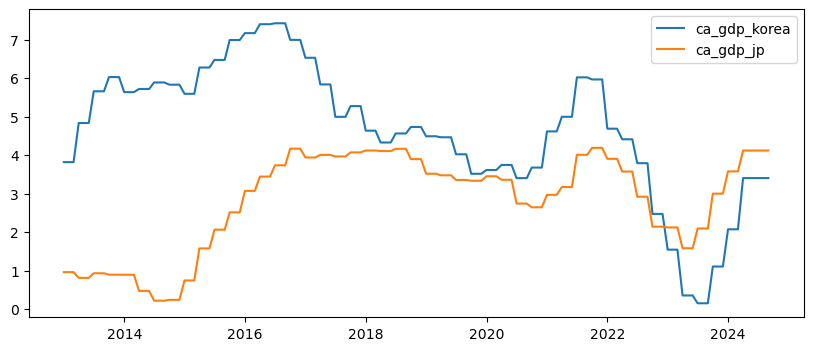

In [51]:
#stationary process
plt.plot(df_merged.loc['2012-12-26':]['ca_gdp_korea'], label = 'ca_gdp_korea')
plt.plot(df_merged.loc['2012-12-26':]['ca_gdp_jp'], label = 'ca_gdp_jp')
plt.legend()
plt.show()

### GDP Growth

In [52]:
df_merged['gdp_growth_korea2'] = df_merged['gdp_korea'].pct_change(periods = 12) * 100
df_merged['gdp_growth_jp2'] = df_merged['gdp_jp'].pct_change(periods = 12) * 100

### Inflation (YoY, Y/Y)

In [53]:
df_merged['infl_korea'] = df_merged['cpi_korea'].pct_change(periods = 12) * 100
df_merged['infl_jp'] = df_merged['cpi_jp'].pct_change(periods = 12) * 100

### 상대적 인플레이션 & 금리 차이

In [54]:
df_merged['infl_diff'] = df_merged['infl_korea'] - df_merged['infl_jp']
df_merged['int_rate_diff'] = df_merged['int_rate_korea'] - df_merged['int_rate_jp']

### GDP 대비 외환보유액 및 증가율

In [55]:
df_merged['reserves_to_gdp'] = df_merged['foreign_reserves'] / df_merged['gdp_korea'] / 1000 * 100
df_merged['reserves_growth'] = df_merged['foreign_reserves'].pct_change(periods = 12) * 100

### 필요한 컬럼만 남김

In [56]:
df_sample = df_merged[[
    'F12.ann_ret', 'real_xr',
    'ca_gdp_korea', 'ca_gdp_jp',
    'gdp_growth_korea', 'gdp_growth_jp',
    'infl_diff', 'int_rate_diff',
    'reserves_to_gdp', 'reserves_growth'
]]

In [57]:
df_sample = df_sample.dropna()
#df_sample = df_sample.loc['1998-12-31':]
df_sample = df_sample['2012-12-31':]

In [58]:
df_sample.head(3)

,F12.ann_ret,real_xr,ca_gdp_korea,ca_gdp_jp,gdp_growth_korea,gdp_growth_jp,infl_diff,int_rate_diff,reserves_to_gdp,reserves_growth
date,,,,,,,,,,
2012-12-31,-19.466132,0.657192,3.817592,0.958443,2.569,0.03,1.646779,2.64,25.583448,6.712055
2013-01-31,-12.180366,0.689834,3.817592,0.958443,2.569,0.03,1.949231,2.63,25.735390,5.643250
2013-02-28,-11.169869,0.697030,3.817592,0.958443,2.569,0.03,2.325197,2.61,25.616855,3.670539


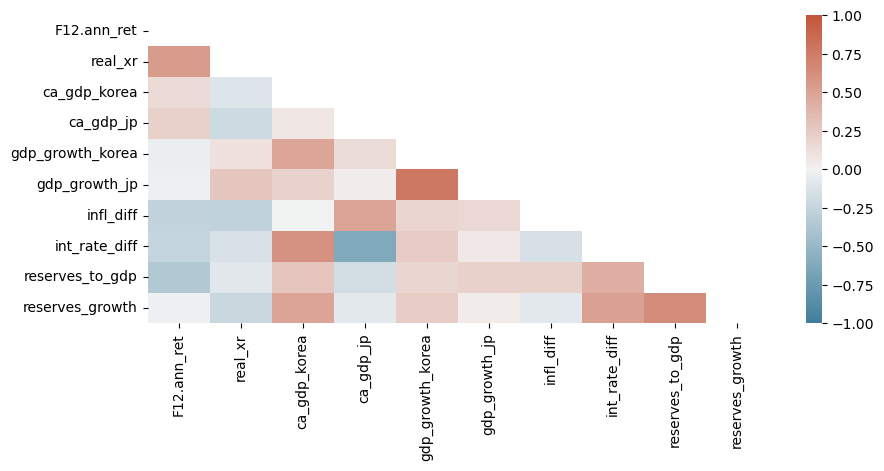

In [59]:
corr = df_sample.corr()
# triu = upper triangle
mask = np.triu(np.ones_like(corr))
cmap=sns.diverging_palette(230, 20, as_cmap = True)
mask=np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask = mask, cmap = cmap, vmin = -1, vmax = 1)
plt.show()

In [60]:
X = df_sample.drop('F12.ann_ret', axis=1)
X = sm.add_constant(X)
Y = df_sample['F12.ann_ret']

sm.OLS(Y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            F12.ann_ret   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     34.81
Date:                Tue, 13 Aug 2024   Prob (F-statistic):           2.43e-29
Time:                        10:26:43   Log-Likelihood:                -371.80
No. Observations:                 129   AIC:                             763.6
Df Residuals:                     119   BIC:                             792.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               25.7269     14.851      1.732      0.086      -3.679      55.133
real_xr             82.9932      7.790     10.653      0.000      67.568      98.419
ca_gdp_korea         2.6805      0.544      4.925      0.000       1.603       3.758
ca_gdp_jp           -0.0776      0.935     -0.083      0.934      -1.929       1.774
gdp_growth_korea    -1.9303      0.539     -3.579      0.000      -2.998      -0.862
gdp_growth_jp        0.2846      0.310      0.920      0.360      -0.328       0.897
infl_diff            0.4478      0.464      0.965      0.337      -0.471       1.367
int_rate_diff       -3.0251      1.161     -2.606      0.010      -5.324      -0.727
reserves_to_gdp     -4.1130      0.538     -7.649      0.000      -5.178      -3.048
reserves_growth      0.9465      0.144      6.574      0.000       0.661       1.232
==============================================================================
Omnibus:                        1.022   Durbin-Watson:                   0.564
Prob(Omnibus):                  0.600   Jarque-Bera (JB):                0.800
Skew:                           0.191   Prob(JB):                        0.670
Kurtosis:                       3.048   Cond. No.                     1.01e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Fetch Additional Datasources

In [61]:
BOK_API_URL = 'https://ecos.bok.or.kr/api'
BOK_API_KEY = 'VO597GC43N9Q7VNFSQW7'

In [62]:
def fetch_bok_data(service_code, stat_code=None, item=None) :
    url = f"{BOK_API_URL}/{service_code}/{BOK_API_KEY}/json/kr/1/100000"

    if item is not None:
        if item['STAT_CODE'] == '902Y023': # ITEM_CODE2가 있는 통계 ... ITEM_CODE1을 'IRLT'로 고정.
            url += "/{}/{}/{}/{}/{}/{}".format(item['STAT_CODE'], item['CYCLE'], item['START_TIME'], item['END_TIME'], 'IRLT', item['ITEM_CODE'])
        
        else:
            url += "/{}/{}/{}/{}/{}".format(item['STAT_CODE'], item['CYCLE'], item['START_TIME'], item['END_TIME'], item['ITEM_CODE'])
         
    elif stat_code : 
        url += f"/{stat_code}"
        
    print(url)
    resp = requests.get(url)
    results = resp.json()
    rows = results[service_code]['row']
    df = pd.DataFrame(rows)

    return df

In [63]:
# Collect Item Codes
stat_codes = fetch_bok_data('StatisticTableList')
stat_codes

https://ecos.bok.or.kr/api/StatisticTableList/VO597GC43N9Q7VNFSQW7/json/kr/1/100000


,P_STAT_CODE,STAT_CODE,STAT_NAME,CYCLE,SRCH_YN,ORG_NAME
0,*,0000000001,1. 통화/금융,None,N,None
1,0000000001,0000000002,1.1. 통화/유동성,None,N,None
2,0000000002,0000000003,1.1.1. 본원통화,None,N,None
3,0000000003,0000000004,1.1.1.1. 본원통화 구성내역,None,N,None
4,0000000004,102Y004,"1.1.1.1.1. 본원통화 구성내역(평잔, 계절조정계열)",M,Y,None
...,...,...,...,...,...,...
972,0000000447,251Y002,9.2.1.2. 한국/북한 배율,A,Y,None
973,0000000396,251Y001,9.2.2. 북한의 경제활동별 국내총생산,A,Y,한국은행
974,0000000396,0000000704,9.2.3. 북한의 시장물가와 환율,None,N,None
975,0000000704,252Y001,9.2.3.1. 시장물가지수,Q,Y,한국은행


In [64]:
TARGET_STAT_CODES = {
    '731Y001': 'krw_xr',           # 3.1.1.1. 주요국 통화의 대원화환율 from 서울외국환중개 - Daily
    '902Y006': 'policy_ir',        # 9.1.1.3. 국제 주요국 중앙은행 정책금리 from BIS - Monthly
    '902Y004': 'mon_base',         # 9.1.1.1. 국제 주요국 본원통화 from IMF - Monthly
    '902Y005': 'mon_broad',        # 9.1.1.2. 국제 주요국 광의통화 from IMF - Monthly
    '902Y012': 'export',           # 9.1.3.4. 국제 주요국 수출(통관기준) from IMF - Monthly
    '902Y013': 'import',           # 9.1.3.5. 국제 주요국 수입(통관기준) from IMF - Monthly
    '902Y014': 'foreign_reserve',  # 9.1.3.6. 국제 주요국 외환보유액 from IMF - Monthly
    '902Y002': 'stock',            # 9.1.6.2. 국제 주요국 주가지수 from OECD - Monthly
    '902Y020': 'ipi',              # 9.1.5.1. 국제 주요국 산업생산지수(계절변동조정) from OECD
    '902Y021': 'unemployment',     # 9.1.5.2. 국제 주요국 실업률(계절변동조정) from OECD - Monthly
    '902Y016': 'gdp',              # 9.1.4.2. 국제 주요국 국내총생산(GDP) from OECD - Annual
    '902Y023': 'irlt',             # 9.1.6.1. 주요국제금리 from OECD - Monthly ... 장기금리
}

In [65]:
dfs = []

for stat_code in TARGET_STAT_CODES.keys() :
    df = fetch_bok_data('StatisticItemList', stat_code=stat_code) # 통계 세부항목 목록
    dfs.append(df)

https://ecos.bok.or.kr/api/StatisticItemList/VO597GC43N9Q7VNFSQW7/json/kr/1/100000/731Y001
https://ecos.bok.or.kr/api/StatisticItemList/VO597GC43N9Q7VNFSQW7/json/kr/1/100000/902Y006
https://ecos.bok.or.kr/api/StatisticItemList/VO597GC43N9Q7VNFSQW7/json/kr/1/100000/902Y004
https://ecos.bok.or.kr/api/StatisticItemList/VO597GC43N9Q7VNFSQW7/json/kr/1/100000/902Y005
https://ecos.bok.or.kr/api/StatisticItemList/VO597GC43N9Q7VNFSQW7/json/kr/1/100000/902Y012
https://ecos.bok.or.kr/api/StatisticItemList/VO597GC43N9Q7VNFSQW7/json/kr/1/100000/902Y013
https://ecos.bok.or.kr/api/StatisticItemList/VO597GC43N9Q7VNFSQW7/json/kr/1/100000/902Y014
https://ecos.bok.or.kr/api/StatisticItemList/VO597GC43N9Q7VNFSQW7/json/kr/1/100000/902Y002
https://ecos.bok.or.kr/api/StatisticItemList/VO597GC43N9Q7VNFSQW7/json/kr/1/100000/902Y020
https://ecos.bok.or.kr/api/StatisticItemList/VO597GC43N9Q7VNFSQW7/json/kr/1/100000/902Y021
https://ecos.bok.or.kr/api/StatisticItemList/VO597GC43N9Q7VNFSQW7/json/kr/1/100000/902Y016

In [66]:
df_items = pd.concat(dfs, axis=0)
#df_items = df_items.set_index(['STAT_CODE', 'ITEM_CODE', 'CYCLE'])

In [67]:
idx01 = df_items['STAT_CODE'] == '731Y001'
idx02 = df_items['ITEM_CODE'] == '0000002'

idx11 = df_items['ITEM_NAME'].str.find('한국') >= 0
idx12 = df_items['ITEM_NAME'].str.find('일본') >= 0
idx13 = df_items['CYCLE'] == 'M'

idx21 = df_items['STAT_CODE'] == '902Y016'

idx31 = df_items['STAT_CODE'] == '902Y023'
idx32 = df_items['ITEM_NAME'].str.find('미국') >= 0

df_items = df_items.loc[(idx01 * idx02) + ((idx11 + idx12) * idx13) + ((idx11 + idx12) * idx21) + (idx31 * idx32 * idx13)]
df_items

,STAT_CODE,STAT_NAME,GRP_CODE,GRP_NAME,ITEM_CODE,ITEM_NAME,P_ITEM_CODE,P_ITEM_NAME,CYCLE,START_TIME,END_TIME,DATA_CNT,UNIT_NAME,WEIGHT
2,731Y001,3.1.1.1. 주요국 통화의 대원화환율,Group1,계정항목,0000002,원/일본엔(100엔),None,None,D,19770401,20240813,13152,원,None
0,902Y006,9.1.1.3. 국제 주요국 중앙은행 정책금리,Group1,계정항목,KR,한국,None,None,M,199905,202406,302,%,None
14,902Y006,9.1.1.3. 국제 주요국 중앙은행 정책금리,Group1,계정항목,JP,일본,None,None,M,194601,202407,827,%,None
1,902Y004,9.1.1.1. 국제 주요국 본원통화,Group1,계정항목,KR,한국,None,None,M,200112,202405,270,백만KRW,None
25,902Y004,9.1.1.1. 국제 주요국 본원통화,Group1,계정항목,JP,일본,None,None,M,200112,202402,267,백만JPY,None
1,902Y005,9.1.1.2. 국제 주요국 광의통화,Group1,계정항목,KR,한국,None,None,M,200112,202404,269,백만KRW,None
23,902Y005,9.1.1.2. 국제 주요국 광의통화,Group1,계정항목,JP,일본,None,None,M,200112,202402,267,백만JPY,None
1,902Y012,9.1.3.4. 국제 주요국 수출(통관기준),Group1,계정항목,KR,한국,None,None,M,200601,202405,221,백만달러,None
67,902Y012,9.1.3.4. 국제 주요국 수출(통관기준),Group1,계정항목,JP,일본,None,None,M,200601,202404,220,백만달러,None
1,902Y013,9.1.3.5. 국제 주요국 수입(통관기준),Group1,계정항목,KR,한국,None,None,M,200601,202405,221,백만달러,None


In [68]:
# iterate over rows
for idx, row in df_items.iterrows():
    name = TARGET_STAT_CODES.get(row['STAT_CODE']) + '_' + row['ITEM_CODE'].lower()
    print(f"Downloading {name}...")

    df = fetch_bok_data('StatisticSearch', item=row) # 통계 조회조건 설정
    df = df[['TIME', 'DATA_VALUE']]

    if row['CYCLE'] == 'D' :
        df['date'] = pd.to_datetime(df['TIME'])
        
    elif row['CYCLE'] == 'M' :
        df['date'] = pd.to_datetime(df['TIME'], format='%Y%m') + MonthEnd()
        
    elif row['CYCLE'] == 'Q' :
        df['year'] = df['TIME'].str[:4]
        df['month'] = df['TIME'].str[-1].astype(int) * 3
        df['day'] = 1
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']]) + MonthEnd()
        
    elif row['CYCLE'] == 'A' :
        df['date'] = pd.to_datetime(df['TIME']) + YearEnd()
        
    else :
        raise RuntimeError()
    
    df = df[['date', 'DATA_VALUE']]
    df = df.rename(columns={'DATA_VALUE': name})
    df[name] = df[name].astype(float)

    df.to_excel(f"data/{name}.xlsx", index=False)
    print()

print("** Completed!! **")

https://ecos.bok.or.kr/api/StatisticSearch/VO597GC43N9Q7VNFSQW7/json/kr/1/100000/731Y001/D/19770401/20240813/0000002

https://ecos.bok.or.kr/api/StatisticSearch/VO597GC43N9Q7VNFSQW7/json/kr/1/100000/902Y006/M/199905/202406/KR

https://ecos.bok.or.kr/api/StatisticSearch/VO597GC43N9Q7VNFSQW7/json/kr/1/100000/902Y006/M/194601/202407/JP

https://ecos.bok.or.kr/api/StatisticSearch/VO597GC43N9Q7VNFSQW7/json/kr/1/100000/902Y004/M/200112/202405/KR

https://ecos.bok.or.kr/api/StatisticSearch/VO597GC43N9Q7VNFSQW7/json/kr/1/100000/902Y004/M/200112/202402/JP

https://ecos.bok.or.kr/api/StatisticSearch/VO597GC43N9Q7VNFSQW7/json/kr/1/100000/902Y005/M/200112/202404/KR

https://ecos.bok.or.kr/api/StatisticSearch/VO597GC43N9Q7VNFSQW7/json/kr/1/100000/902Y005/M/200112/202402/JP

https://ecos.bok.or.kr/api/StatisticSearch/VO597GC43N9Q7VNFSQW7/json/kr/1/100000/902Y012/M/200601/202405/KR

https://ecos.bok.or.kr/api/StatisticSearch/VO597GC43N9Q7VNFSQW7/json/kr/1/100000/902Y012/M/200601/202404/JP

https://ec

In [69]:
filenames = [
    'krw_xr_0000002',
    'policy_ir_kr',
    'policy_ir_jp',
    'mon_base_kr',
    'mon_base_jp',
    'mon_broad_kr',
    'mon_broad_jp',
    'export_kr',
    'export_jp',
    'import_kr',
    'import_jp',
    'foreign_reserve_kr',
    'foreign_reserve_jp',
    'stock_kor',
    'stock_jpn',
    'ipi_kor',
    'ipi_jpn',
    'unemployment_kor',
    'unemployment_jpn',
    'gdp_kor',
    'gdp_jpn',
    'wui_kor',
    'wui_jpn',
    'irlt_kor',
    'irlt_usa',
    'irlt_jpn',
]

In [70]:
dfs = []

for fname in filenames :
    print(f"Loading {fname}...")

    df = pd.read_excel(f"data/{fname}.xlsx")
    df = df.set_index('date')

    dfs.append(df)

print("** Completed! **")
dfs

Loading krw_xr_0000002...
Loading policy_ir_kr...
Loading policy_ir_jp...
Loading mon_base_kr...
Loading mon_base_jp...
Loading mon_broad_kr...
Loading mon_broad_jp...
Loading export_kr...
Loading export_jp...
Loading import_kr...
Loading import_jp...
Loading foreign_reserve_kr...
Loading foreign_reserve_jp...
Loading stock_kor...
Loading stock_jpn...
Loading ipi_kor...
Loading ipi_jpn...
Loading unemployment_kor...
Loading unemployment_jpn...
Loading gdp_kor...
Loading gdp_jpn...
Loading wui_kor...
Loading wui_jpn...
Loading irlt_kor...
Loading irlt_usa...
Loading irlt_jpn...
** Completed! **


[            krw_xr_0000002
 date                      
 1977-04-01          174.50
 1977-04-02          174.50
 1977-04-04          174.50
 1977-04-06          177.40
 1977-04-07          177.23
 ...                    ...
 2024-08-07          949.49
 2024-08-08          940.13
 2024-08-09          934.32
 2024-08-12          931.09
 2024-08-13          929.08
 
 [13152 rows x 1 columns],
             policy_ir_kr
 date                    
 1999-05-31          4.75
 1999-06-30          4.75
 1999-07-31          4.75
 1999-08-31          4.75
 1999-09-30          4.75
 ...                  ...
 2024-02-29          3.50
 2024-03-31          3.50
 2024-04-30          3.50
 2024-05-31          3.50
 2024-06-30          3.50
 
 [302 rows x 1 columns],
             policy_ir_jp
 date                    
 1946-01-31          3.29
 1946-02-28          3.29
 1946-03-31          3.29
 1946-04-30          3.29
 1946-05-31          3.29
 ...                  ...
 2024-03-31          0.05
 2024-04

In [71]:
df_merged = pd.concat(dfs, axis=1)
df_merged.rename(columns={'krw_xr_0000002': 'krw_jpy_xr'}, inplace=True)
df_merged = df_merged.sort_index()
df_merged.head(3)

,krw_jpy_xr,policy_ir_kr,policy_ir_jp,mon_base_kr,mon_base_jp,mon_broad_kr,mon_broad_jp,export_kr,export_jp,import_kr,...,ipi_jpn,unemployment_kor,unemployment_jpn,gdp_kor,gdp_jpn,wui_kor,wui_jpn,irlt_kor,irlt_usa,irlt_jpn
date,,,,,,,,,,,,,,,,,,,,,
1946-01-31,NaN,NaN,3.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-02-28,NaN,NaN,3.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-03-31,NaN,NaN,3.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
df_merged = df_merged['2012-12-31':]
df_merged = df_merged.resample('M').last()
df_merged = df_merged.ffill()
df_merged.head(3)

,krw_jpy_xr,policy_ir_kr,policy_ir_jp,mon_base_kr,mon_base_jp,mon_broad_kr,mon_broad_jp,export_kr,export_jp,import_kr,...,ipi_jpn,unemployment_kor,unemployment_jpn,gdp_kor,gdp_jpn,wui_kor,wui_jpn,irlt_kor,irlt_usa,irlt_jpn
date,,,,,,,,,,,,,,,,,,,,,
2012-12-31,1247.50,2.75,0.05,88341969.4,138474700.0,1.835642e+09,1.145105e+09,45032.0,63397.0,43109.0,...,97.4,3.1,4.3,1278046.6,6272363.0,NaN,NaN,3.13,1.72,0.78
2013-01-31,1188.47,2.75,0.05,83206115.4,130938400.0,1.844601e+09,1.147010e+09,45674.0,53820.0,45279.0,...,95.4,3.1,4.2,1278046.6,6272363.0,0.069979,0.395928,3.05,1.91,0.78
2013-02-28,1176.20,2.75,0.05,94843448.4,131304200.0,1.853813e+09,1.153551e+09,42336.0,56708.0,40431.0,...,97.0,3.2,4.3,1278046.6,6272363.0,0.069979,0.395928,3.04,1.98,0.67


In [73]:
df_merged_wsj = df_merged.copy()

In [74]:
# Y. F12.ann_ret
df_merged['ann_ret'] = df_merged['krw_jpy_xr'].pct_change(periods=12) * 100
df_merged['F12.ann_ret'] = df_merged['ann_ret'].shift(-12)
df_merged[['ann_ret', 'F12.ann_ret']]

,ann_ret,F12.ann_ret
date,,
2012-12-31,NaN,-19.466132
2013-01-31,NaN,-12.180366
2013-02-28,NaN,-11.169869
2013-03-31,NaN,-11.981731
2013-04-30,NaN,-11.194834
...,...,...
2024-04-30,-11.787574,NaN
2024-05-31,-7.203112,NaN
2024-06-30,-4.703573,NaN


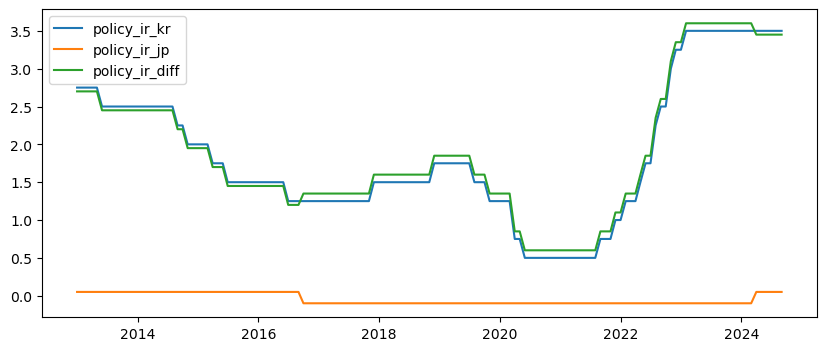

In [75]:
# X1. 한일 정책금리 차이
df_merged['policy_ir_diff'] = df_merged['policy_ir_kr'] - df_merged['policy_ir_jp']
df_merged['policy_ir_diff_rt'] = df_merged['policy_ir_diff'].pct_change(periods=12) * 100

plt.rcParams['figure.figsize'] = (10, 4)

plt.plot(df_merged[['policy_ir_kr', 'policy_ir_jp', 'policy_ir_diff']], label = ['policy_ir_kr', 'policy_ir_jp', 'policy_ir_diff'])
plt.legend()
plt.show()

In [76]:
adf_result = adfuller(df_merged['policy_ir_diff'])
adf_result[1] # adf_result[1] < 0.05이면 stationary

0.5189841023006627

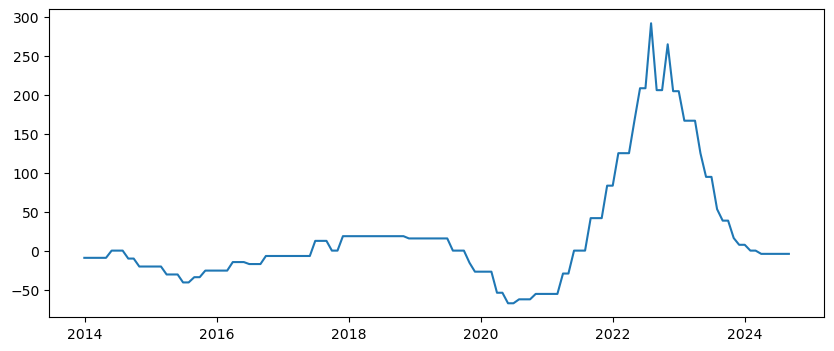

In [77]:
plt.plot(df_merged[['policy_ir_diff_rt']])
plt.show()

In [78]:
adf_result = adfuller(df_merged['policy_ir_diff_rt'].dropna())
adf_result[1] # adf_result[1] < 0.05이면 stationary

0.002660845473550321

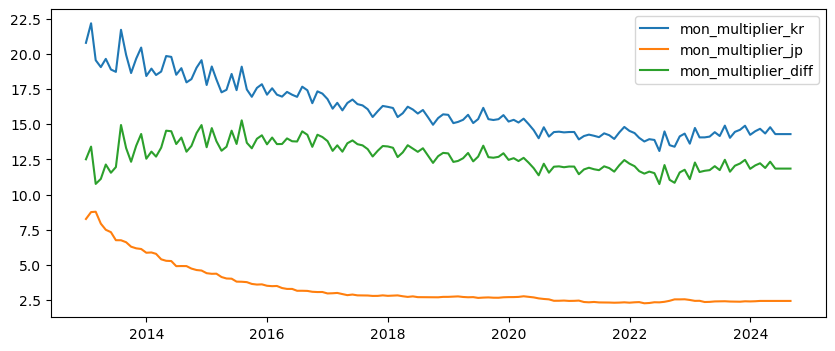

In [79]:
# X2. 한일 통화승수 차이
df_merged['mon_multiplier_kr'] = df_merged['mon_broad_kr'] / df_merged['mon_base_kr']
df_merged['mon_multiplier_jp'] = df_merged['mon_broad_jp'] / df_merged['mon_base_jp']
df_merged['mon_multiplier_diff'] = df_merged['mon_multiplier_kr'] - df_merged['mon_multiplier_jp']
df_merged['mon_multiplier_diff_rt'] = df_merged['mon_multiplier_diff'].pct_change(periods=12) * 100

plt.plot(df_merged[['mon_multiplier_kr', 'mon_multiplier_jp', 'mon_multiplier_diff']], label = ['mon_multiplier_kr', 'mon_multiplier_jp', 'mon_multiplier_diff'])
plt.legend()
plt.show()

In [80]:
adf_result = adfuller(df_merged['mon_multiplier_diff'])
adf_result[1] # adf_result[1] < 0.05이면 stationary

0.8241335243750392

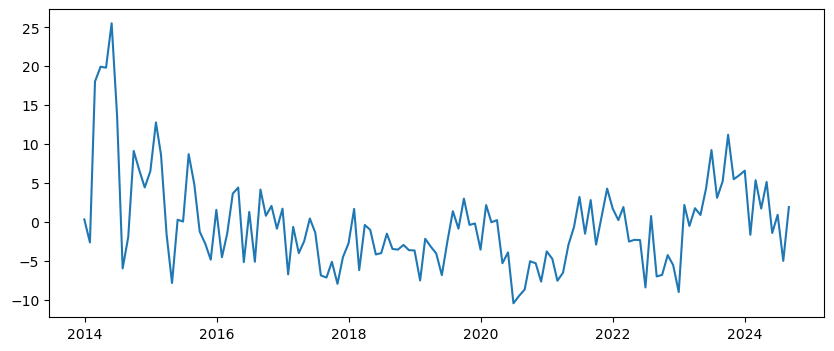

In [81]:
plt.plot(df_merged[['mon_multiplier_diff_rt']])
plt.show()

In [82]:
adf_result = adfuller(df_merged['mon_multiplier_diff_rt'].dropna())
adf_result[1] # adf_result[1] < 0.05이면 stationary

0.03821653474335621

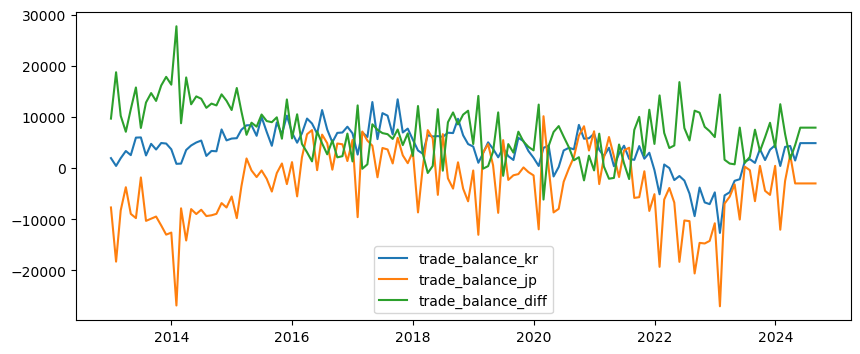

In [83]:
# X3. 한일 무역수지 차이
df_merged['trade_balance_kr'] = df_merged['export_kr'] - df_merged['import_kr']
df_merged['trade_balance_jp'] = df_merged['export_jp'] - df_merged['import_jp']
df_merged['trade_balance_diff'] = df_merged['trade_balance_kr'] - df_merged['trade_balance_jp']
plt.plot(df_merged[['trade_balance_kr', 'trade_balance_jp', 'trade_balance_diff']], label = ['trade_balance_kr', 'trade_balance_jp', 'trade_balance_diff'])
plt.legend()
plt.show()

In [84]:
adf_result = adfuller(df_merged['trade_balance_diff'])
adf_result[1] # adf_result[1] < 0.05이면 stationary

0.02729198583433303

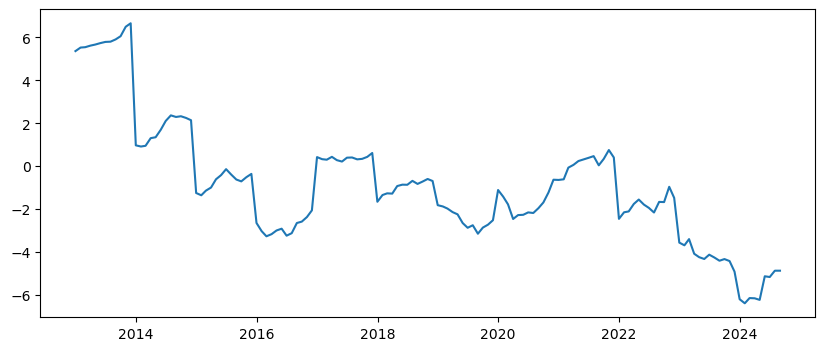

In [85]:
# X4. 한일 GDP 대비 외환보유액 차이
df_merged['foreign_reserve_to_gdp_kr'] = df_merged['foreign_reserve_kr'] / df_merged['gdp_kor'] * 100
df_merged['foreign_reserve_to_gdp_jp'] = df_merged['foreign_reserve_jp'] / df_merged['gdp_jpn'] * 100
df_merged['foreign_reserve_to_gdp_diff'] = df_merged['foreign_reserve_to_gdp_kr'] - df_merged['foreign_reserve_to_gdp_jp']
df_merged['foreign_reserve_to_gdp_diff_rt'] = df_merged['foreign_reserve_to_gdp_diff'].pct_change(periods=12) * 100

plt.plot(df_merged[['foreign_reserve_to_gdp_diff']])
plt.show()

In [86]:
adf_result = adfuller(df_merged['foreign_reserve_to_gdp_diff'])
adf_result[1] # adf_result[1] < 0.05이면 stationary

0.22716228476660905

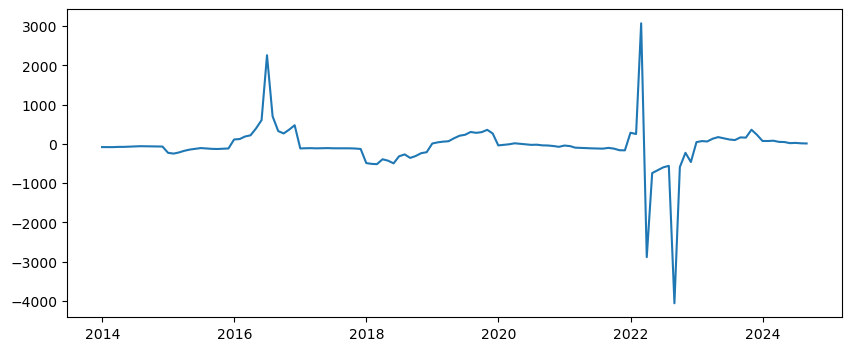

In [87]:
plt.plot(df_merged[['foreign_reserve_to_gdp_diff_rt']])
plt.show()

In [88]:
adf_result = adfuller(df_merged['foreign_reserve_to_gdp_diff_rt'].dropna())
adf_result[1] # adf_result[1] < 0.05이면 stationary

0.0016962261429725122

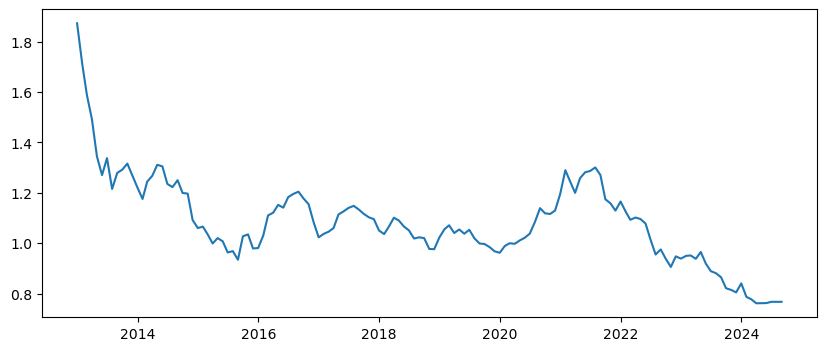

In [89]:
# X5. 한일 주가지수 비율
df_merged['stock_ratio'] = df_merged['stock_kor'] / df_merged['stock_jpn']

plt.plot(df_merged[['stock_ratio']])
plt.show()

In [90]:
adf_result = adfuller(df_merged['stock_ratio'].dropna())
adf_result[1] # adf_result[1] < 0.05이면 stationary

0.011187498870677272

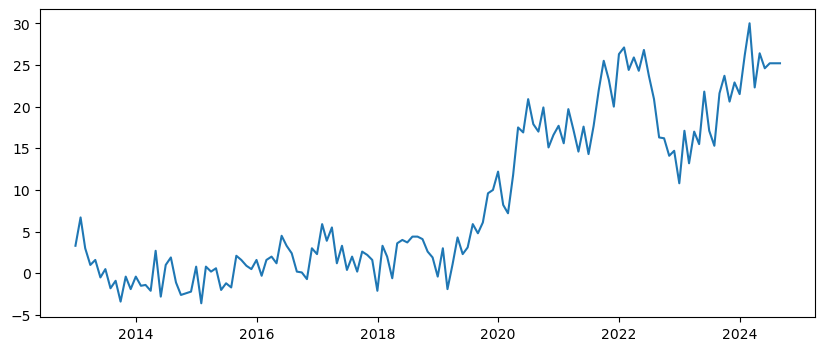

In [91]:
# X6. 한일 산업생산지수(IPI) 차이
df_merged['ipi_diff'] = df_merged['ipi_kor'] - df_merged['ipi_jpn']
df_merged['ipi_diff_rt'] = df_merged['ipi_diff'].pct_change(periods=12) * 100

plt.plot(df_merged[['ipi_diff']])
plt.show()

In [92]:
adf_result = adfuller(df_merged['ipi_diff'])
adf_result[1] # adf_result[1] < 0.05이면 stationary

0.9722417316265288

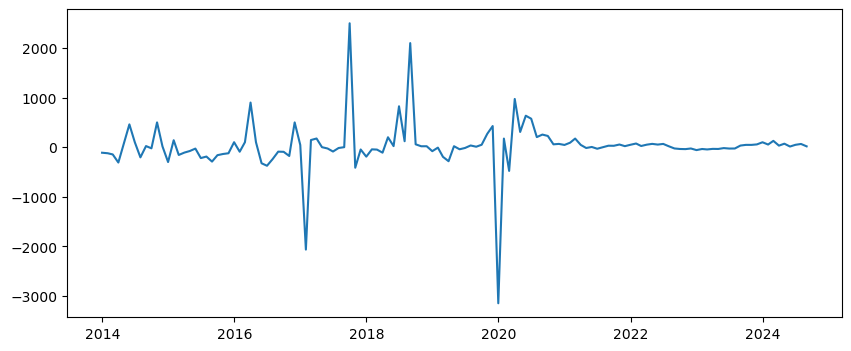

In [93]:
plt.plot(df_merged[['ipi_diff_rt']])
plt.show()

In [94]:
adf_result = adfuller(df_merged['ipi_diff_rt'].dropna())
adf_result[1] # adf_result[1] < 0.05이면 stationary

1.1026084889979238e-21

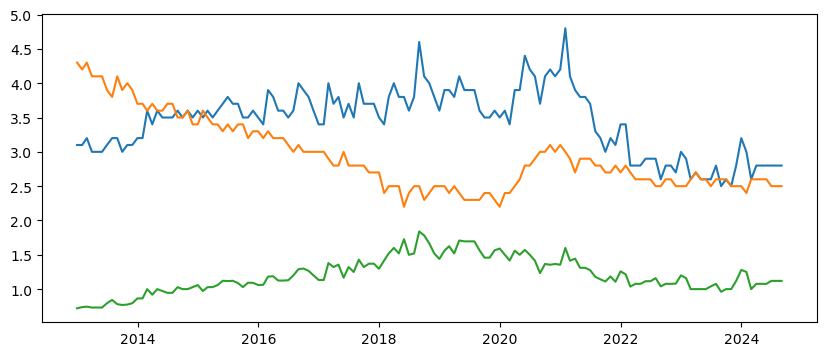

In [95]:
# X7. 한일 실업률 비율
df_merged['unemployment_ratio'] = df_merged['unemployment_kor'] / df_merged['unemployment_jpn']

plt.plot(df_merged[['unemployment_kor', 'unemployment_jpn', 'unemployment_ratio']])
plt.show()

In [96]:
adf_result = adfuller(df_merged['unemployment_ratio'].dropna())
adf_result # adf_result[1] < 0.05이면 stationary

(-1.8114684651161566,
 0.37478296749443,
 14,
 126,
 {'1%': -3.4833462346078936,
  '5%': -2.8847655969877666,
  '10%': -2.5791564575459813},
 -246.70898829964187)

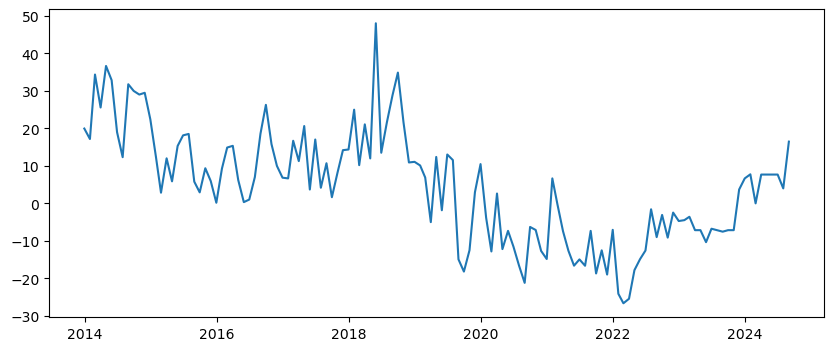

In [97]:
df_merged['unemployment_ratio_rt'] =  df_merged['unemployment_ratio'].pct_change(periods=12) * 100
plt.plot(df_merged[['unemployment_ratio_rt']])
plt.show()

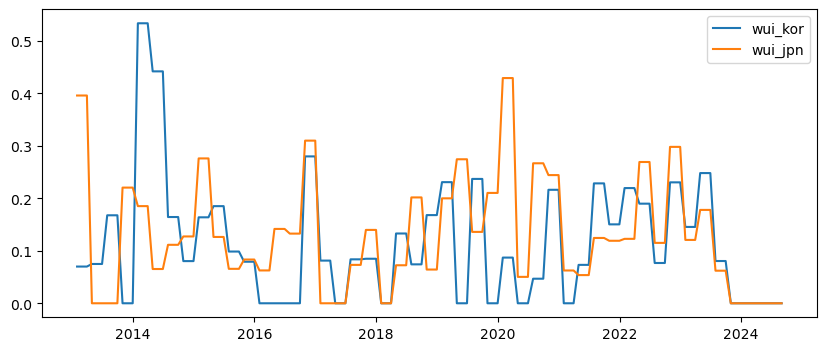

In [98]:
# X8. 한일 World Uncertainty Index(IMF) 차이
plt.plot(df_merged[['wui_kor', 'wui_jpn']], label = ['wui_kor','wui_jpn'])
plt.legend()
plt.show()

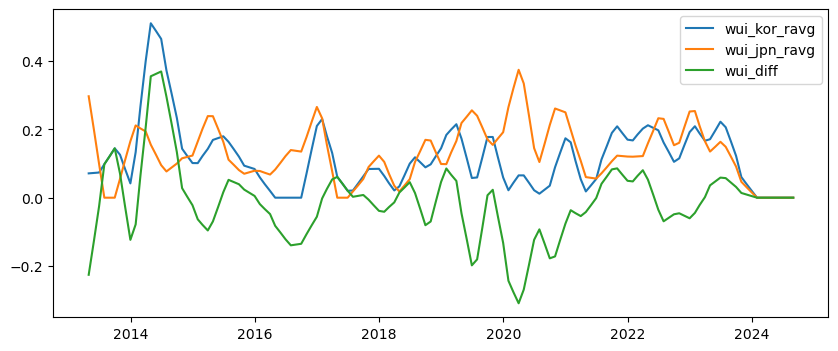

In [99]:
df_merged['wui_kor_ravg'] = df_merged['wui_kor'].rolling(4).mean()
df_merged['wui_jpn_ravg'] = df_merged['wui_jpn'].rolling(4).mean()
df_merged['wui_diff'] = df_merged['wui_kor_ravg'] - df_merged['wui_jpn_ravg']

plt.plot(df_merged[['wui_kor_ravg', 'wui_jpn_ravg', 'wui_diff']], label = ['wui_kor_ravg', 'wui_jpn_ravg', 'wui_diff'])
plt.legend()
plt.show()

In [100]:
adf_result = adfuller(df_merged['wui_diff'].dropna())
adf_result[1] # adf_result[1] < 0.05이면 statioanary

0.0022696429651886075

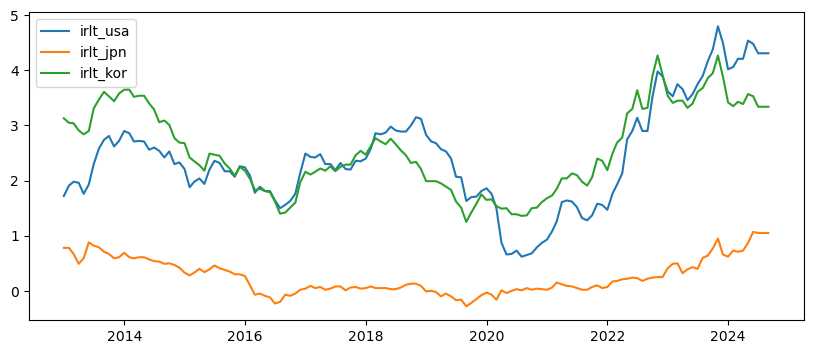

In [101]:
# X9. 미일 장기금리 차이
plt.plot(df_merged[['irlt_usa', 'irlt_jpn', 'irlt_kor']], label = ['irlt_usa', 'irlt_jpn', 'irlt_kor'])
plt.legend()
plt.show()

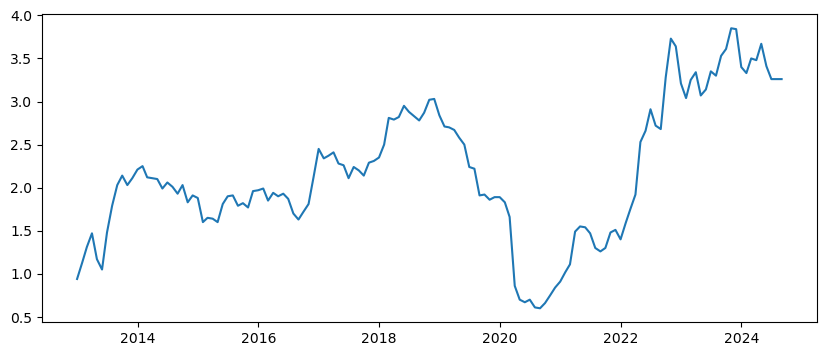

In [102]:
df_merged['irlt_usd_jpn_diff'] = df_merged['irlt_usa'] - df_merged['irlt_jpn']
plt.plot(df_merged[['irlt_usd_jpn_diff']])
plt.show()

In [103]:
adf_result = adfuller(df_merged['irlt_usd_jpn_diff'])
adf_result # adf_result[1] < 0.05이면 stationary

(-2.2316825412825447,
 0.19494808266546926,
 5,
 135,
 {'1%': -3.479742586699182,
  '5%': -2.88319822181578,
  '10%': -2.578319684499314},
 -80.00060605299294)

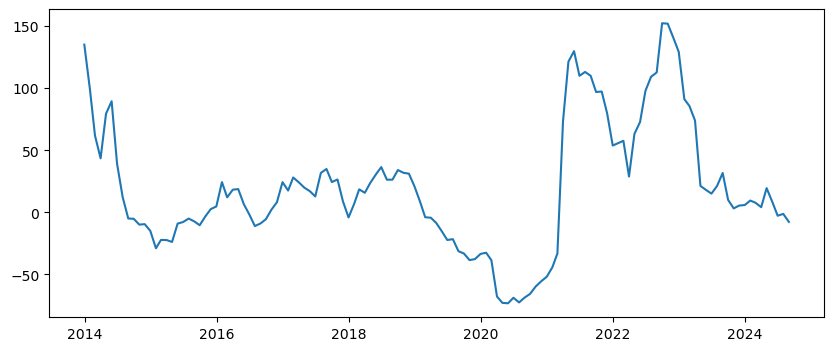

In [104]:
df_merged['irlt_usd_jpn_diff_rt'] = df_merged['irlt_usd_jpn_diff'].pct_change(periods=12) * 100
plt.plot(df_merged[['irlt_usd_jpn_diff_rt']])
plt.show()

In [105]:
adf_result = adfuller(df_merged['irlt_usd_jpn_diff_rt'].dropna())
adf_result # adf_result[1] < 0.05이면 stationary

(-2.314099400918719,
 0.16746094833699604,
 13,
 115,
 {'1%': -3.4885349695076844,
  '5%': -2.887019521656941,
  '10%': -2.5803597920604915},
 941.47535495428)

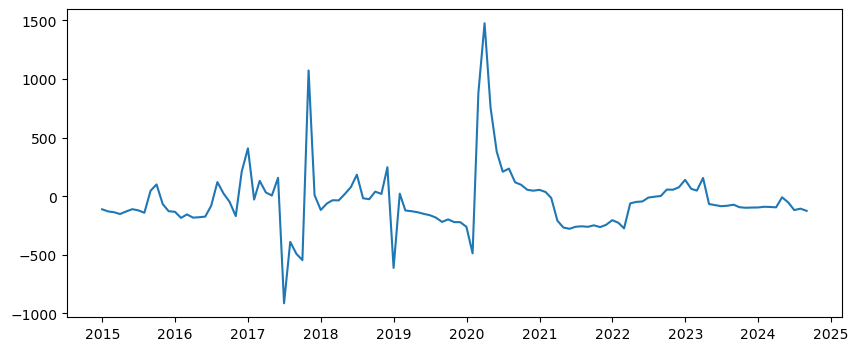

In [106]:
df_merged['irlt_usd_jpn_diff_rt'] = df_merged['irlt_usd_jpn_diff_rt'].pct_change(periods=12) * 100 # 2차 차분
plt.plot(df_merged[['irlt_usd_jpn_diff_rt']])
plt.show()

In [107]:
adf_result = adfuller(df_merged['irlt_usd_jpn_diff_rt'].dropna())
adf_result # adf_result[1] < 0.05이면 stationary

(-6.73993211997562,
 3.137546936310534e-09,
 0,
 116,
 {'1%': -3.4880216384691867,
  '5%': -2.8867966864160075,
  '10%': -2.5802408234244947},
 1445.918482801484)

In [108]:
df_added = df_merged[[
    'policy_ir_diff_rt',               # X1. 한일 정책금리 차이
    'mon_multiplier_diff_rt',          # X2. 한일 통화승수 차이
    'trade_balance_diff',              # X3. 한일 무역수지 차이
    'foreign_reserve_to_gdp_diff_rt',  # X4. 한일 GDP 대비 외환보유액 차이
    'stock_ratio',                     # X5. 한일 주가지수 비율
    'ipi_diff_rt',                     # X6. 한일 산업생산지수(IPI) 차이
    'unemployment_ratio_rt',           # X7. 한일 실업률 비율
    'wui_diff',                        # X8. 한일 World Uncertainty Index(IMF) 차이
    'irlt_usd_jpn_diff_rt',            # X9. 미일 장기금리 차이
    'F12.ann_ret'                      # Y. 수익률(12개월 전)
]]
df_added = df_added.dropna()
df_added.head(15), df_added.tail(15)

(            policy_ir_diff_rt  mon_multiplier_diff_rt  trade_balance_diff  \
 date                                                                        
 2014-12-31         -20.408163                6.501963             11328.0   
 2015-01-31         -20.408163               12.772308             15636.0   
 2015-02-28         -20.408163                8.631566             11062.0   
 2015-03-31         -30.612245               -1.624997              6481.0   
 2015-04-30         -30.612245               -7.849954              8851.0   
 2015-05-31         -30.612245                0.281023              8069.0   
 2015-06-30         -40.816327                0.044830             10449.0   
 2015-07-31         -40.816327                8.700754              9169.0   
 2015-08-31         -34.090909                4.855950              8949.0   
 2015-09-30         -34.090909               -1.245396              9900.0   
 2015-10-31         -25.641026               -2.810345          

In [109]:
### Use OLS to fit the forecast model
Y = df_added['F12.ann_ret']
X = df_added.drop('F12.ann_ret', axis=1)
X = sm.add_constant(X)

model = sm.OLS(Y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            F12.ann_ret   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     11.93
Date:                Tue, 13 Aug 2024   Prob (F-statistic):           2.19e-12
Time:                        10:27:24   Log-Likelihood:                -325.41
No. Observations:                 105   AIC:                             670.8
Df Residuals:                      95   BIC:                             697.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             31.8352      7.522      4.233      0.000      16.903      46.767
policy_ir_diff_rt                 -0.0454      0.009     -5.193      0.000      -0.063      -0.028
mon_multiplier_diff_rt            -0.0505      0.133     -0.379      0.706      -0.315       0.214
trade_balance_diff                 0.0002      0.000      1.505      0.136   -6.31e-05       0.000
foreign_reserve_to_gdp_diff_rt    -0.0018      0.001     -2.038      0.044      -0.004   -4.69e-05
stock_ratio                      -30.0201      6.806     -4.411      0.000     -43.531     -16.509
ipi_diff_rt                    -8.625e-05      0.001     -0.083      0.934      -0.002       0.002
unemployment_ratio_rt              0.1961      0.043      4.592      0.000       0.111       0.281
wui_diff                          25.2154      7.748      3.255      0.002       9.834      40.597
irlt_usd_jpn_diff_rt              -0.0038      0.002     -1.752      0.083      -0.008       0.001
==============================================================================
Omnibus:                        3.437   Durbin-Watson:                   0.675
Prob(Omnibus):                  0.179   Jarque-Bera (JB):                3.281
Skew:                           0.431   Prob(JB):                        0.194
Kurtosis:                       2.923   Cond. No.                     1.35e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [110]:
# X10. 일본의 장단기 금리차
df_merged_ssg, df_merged_wsj

(            krw_100jpy_xr  current_account_korea  current_account_us  \
 date                                                                   
 1947-06-30            NaN                    NaN                 NaN   
 1947-07-31            NaN                    NaN                 NaN   
 1947-08-31            NaN                    NaN                 NaN   
 1947-09-30            NaN                    NaN                 NaN   
 1947-10-31            NaN                    NaN                 NaN   
 ...                   ...                    ...                 ...   
 2024-04-30         882.68                58283.7           -913345.0   
 2024-05-31         877.84                58283.7           -913345.0   
 2024-06-30         864.31                58283.7           -913345.0   
 2024-07-31         905.44                58283.7           -913345.0   
 2024-08-31         929.08                58283.7           -913345.0   
 
             current_account_jp  gdp_korea      g

In [111]:
df_ir_jpn = pd.concat([df_merged_ssg['int_rate_jp'], df_merged_wsj['irlt_jpn']], axis=1)
df_ir_jpn

,int_rate_jp,irlt_jpn
date,,
1947-06-30,NaN,NaN
1947-07-31,NaN,NaN
1947-08-31,NaN,NaN
1947-09-30,NaN,NaN
1947-10-31,NaN,NaN
...,...,...
2024-04-30,5.33,0.87
2024-05-31,5.33,1.07
2024-06-30,5.28,1.05


In [112]:
df_ir_jpn = df_ir_jpn['2012-12-31':]
df_ir_jpn = df_ir_jpn.resample('M').last()
df_ir_jpn = df_ir_jpn.ffill()
df_ir_jpn

,int_rate_jp,irlt_jpn
date,,
2012-12-31,0.24,0.78
2013-01-31,0.23,0.78
2013-02-28,0.22,0.67
2013-03-31,0.21,0.49
2013-04-30,0.20,0.59
...,...,...
2024-04-30,5.33,0.87
2024-05-31,5.33,1.07
2024-06-30,5.28,1.05


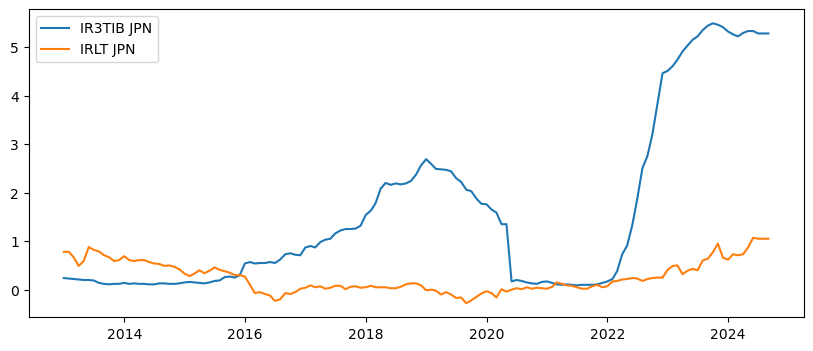

In [113]:
plt.plot(df_ir_jpn['int_rate_jp'], label='IR3TIB JPN')
plt.plot(df_ir_jpn['irlt_jpn'], label='IRLT JPN')
plt.legend()
plt.show()

In [114]:
df_ir_jpn['ir_jpn_diff'] = df_ir_jpn['int_rate_jp'] - df_ir_jpn['irlt_jpn']

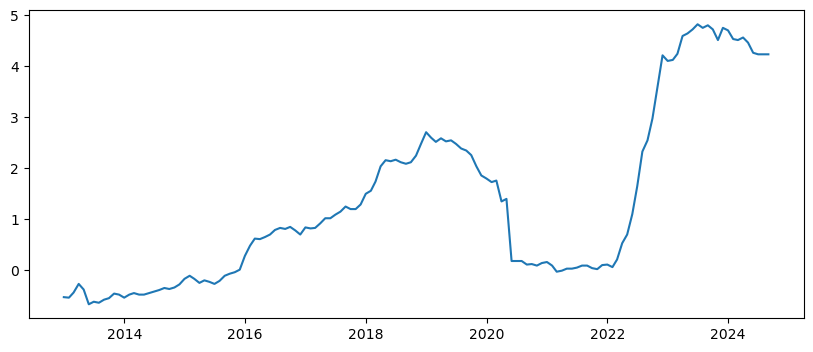

In [115]:
plt.plot(df_ir_jpn['ir_jpn_diff'])
plt.show()

In [116]:
adf_result = adfuller(df_ir_jpn['ir_jpn_diff'].dropna())
adf_result[1] # adf_result[1] < 0.05이면 stationary

0.4706170703043968

In [117]:
df_ir_jpn['ir_jpn_diff_rt'] = (df_ir_jpn['ir_jpn_diff']+1).pct_change(periods=12) * 100

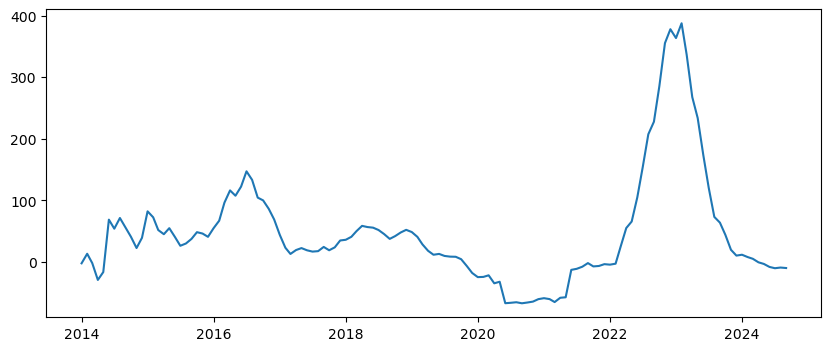

In [118]:
plt.plot(df_ir_jpn['ir_jpn_diff_rt'])
plt.show()

In [119]:
adf_result = adfuller(df_ir_jpn['ir_jpn_diff_rt'].dropna())
adf_result[1] # adf_result[1] < 0.05이면 stationary

0.026779535866143737

### 이제 모든 변수를 모아보자.

In [120]:
df_added['ir_jpn_diff_rt']   = df_ir_jpn['ir_jpn_diff_rt']   # X10. 일본의 장단기 금리차
df_added['real_xr']          = df_sample['real_xr']          # X11. Real XR
df_added['ca_gdp_korea']     = df_sample['ca_gdp_korea']     # X12. GDP 대비 경상수지_한국
df_added['ca_gdp_jp']        = df_sample['ca_gdp_jp']        # X13. GDP 대비 경상수지_일본
df_added['gdp_growth_korea'] = df_sample['gdp_growth_korea'] # X14. GDP 성장률_한국
df_added['gdp_growth_jp']    = df_sample['gdp_growth_jp']    # X15. GDP 성장률_일본
df_added['infl_diff']        = df_sample['infl_diff']        # X16. 물가인상율 차이 
df_added['int_rate_diff']    = df_sample['int_rate_diff']    # X17. 한일 단기금리 차이
df_added['reserves_to_gdp']  = df_sample['reserves_to_gdp']  # X18. 한국 GDP 대비 외환보유고
df_added['reserves_growth']  = df_sample['reserves_growth']  # X19. 한국 GDP 대비 외환보유고 증가율

df_added

,policy_ir_diff_rt,mon_multiplier_diff_rt,trade_balance_diff,foreign_reserve_to_gdp_diff_rt,stock_ratio,ipi_diff_rt,unemployment_ratio_rt,wui_diff,irlt_usd_jpn_diff_rt,F12.ann_ret,ir_jpn_diff_rt,real_xr,ca_gdp_korea,ca_gdp_jp,gdp_growth_korea,gdp_growth_jp,infl_diff,int_rate_diff,reserves_to_gdp,reserves_growth
date,,,,,,,,,,,,,,,,,,,,
2014-12-31,-20.408163,6.501963,11328.0,-228.287041,1.060440,-300.000000,22.426471,-0.022001,-111.052125,5.637186,82.222222,0.919486,5.593145,0.742322,2.506,-0.444,-1.566283,1.98,24.492797,4.945217
2015-01-31,-20.408163,12.772308,15636.0,-247.595088,1.065848,140.000000,12.413194,-0.063297,-129.146825,10.394417,72.549020,0.918268,5.593145,0.742322,2.506,-0.444,-1.435851,1.97,24.398046,3.958846
2015-02-28,-20.408163,8.631566,11062.0,-219.578939,1.036132,-157.142857,2.857143,-0.079611,-135.854880,17.932705,51.851852,0.918907,5.593145,0.742322,2.506,-0.444,-1.560807,1.97,24.410433,3.006982
2015-03-31,-30.612245,-1.624997,6481.0,-176.022841,0.999002,-109.523810,12.024221,-0.095925,-151.162618,11.492404,45.098039,0.919366,6.276270,1.575062,2.603,0.288,-1.830776,1.81,24.436044,2.373111
2015-04-30,-30.612245,-7.849954,8851.0,-145.125082,1.020448,-77.777778,5.882353,-0.069500,-129.953917,17.940973,54.901961,0.942975,6.276270,1.575062,2.603,0.288,-0.287291,1.68,24.917814,3.950217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30,125.000000,0.888994,711.0,172.803069,0.965385,-36.213992,-7.142857,0.036113,-66.241833,-11.787574,233.727811,0.853127,0.352616,1.579321,1.176,2.433,0.145276,-1.53,25.490139,-5.033205
2023-05-31,94.594595,4.288711,7889.0,141.647125,0.918741,-18.656716,-10.344828,0.047477,-75.187970,-7.203112,173.684211,0.902413,0.352616,1.579321,1.176,2.433,0.133449,-1.51,25.149604,-5.969863
2023-06-30,94.594595,9.229327,984.0,112.248636,0.889271,-27.848101,-6.758621,0.058840,-84.564719,-4.703573,120.454545,0.941227,0.149446,2.093027,0.929,2.204,-0.604380,-1.47,25.177715,-3.838753


In [121]:
### Use OLS to fit the forecast model
Y = df_added['F12.ann_ret']
X = df_added.drop('F12.ann_ret', axis=1)
X = sm.add_constant(X)

model = sm.OLS(Y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            F12.ann_ret   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     22.55
Date:                Tue, 13 Aug 2024   Prob (F-statistic):           2.03e-25
Time:                        10:27:24   Log-Likelihood:                -270.69
No. Observations:                 105   AIC:                             581.4
Df Residuals:                      85   BIC:                             634.5
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -4.0994     22.471     -0.182      0.856     -48.778      40.579
policy_ir_diff_rt                  0.0202      0.017      1.182      0.241      -0.014       0.054
mon_multiplier_diff_rt            -0.2314      0.102     -2.270      0.026      -0.434      -0.029
trade_balance_diff              7.066e-05   9.26e-05      0.763      0.447      -0.000       0.000
foreign_reserve_to_gdp_diff_rt     0.0003      0.001      0.556      0.579      -0.001       0.002
stock_ratio                      -14.1257      8.928     -1.582      0.117     -31.877       3.625
ipi_diff_rt                        0.0004      0.001      0.636      0.526      -0.001       0.002
unemployment_ratio_rt              0.0566      0.044      1.298      0.198      -0.030       0.143
wui_diff                           1.3496      6.359      0.212      0.832     -11.294      13.993
irlt_usd_jpn_diff_rt              -0.0012      0.001     -0.816      0.417      -0.004       0.002
ir_jpn_diff_rt                    -0.0343      0.012     -2.902      0.005      -0.058      -0.011
real_xr                           80.4017     14.485      5.551      0.000      51.602     109.202
ca_gdp_korea                       3.3595      0.729      4.608      0.000       1.910       4.809
ca_gdp_jp                         -2.9020      1.083     -2.679      0.009      -5.056      -0.748
gdp_growth_korea                  -0.2932      0.578     -0.507      0.613      -1.442       0.856
gdp_growth_jp                     -0.0586      0.321     -0.183      0.855      -0.696       0.579
infl_diff                         -0.9809      0.692     -1.418      0.160      -2.357       0.395
int_rate_diff                     -4.4611      1.261     -3.536      0.001      -6.969      -1.953
reserves_to_gdp                   -2.0521      0.645     -3.180      0.002      -3.335      -0.769
reserves_growth                    0.7401      0.229      3.231      0.002       0.285       1.195
==============================================================================
Omnibus:                        0.001   Durbin-Watson:                   0.984
Prob(Omnibus):                  0.999   Jarque-Bera (JB):                0.076
Skew:                          -0.007   Prob(JB):                        0.963
Kurtosis:                       2.869   Cond. No.                     5.34e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.34e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [122]:
# AIC를 이용한 Model Selection

min_aic = results.aic
min_aic

581.3786010398803

In [123]:
def find_largest_pvalue_index(res):
    return max([(pval, idx) for idx, pval in enumerate(res.pvalues) ])[1]

In [124]:
selected = X.columns.tolist()
selected

['const',
 'policy_ir_diff_rt',
 'mon_multiplier_diff_rt',
 'trade_balance_diff',
 'foreign_reserve_to_gdp_diff_rt',
 'stock_ratio',
 'ipi_diff_rt',
 'unemployment_ratio_rt',
 'wui_diff',
 'irlt_usd_jpn_diff_rt',
 'ir_jpn_diff_rt',
 'real_xr',
 'ca_gdp_korea',
 'ca_gdp_jp',
 'gdp_growth_korea',
 'gdp_growth_jp',
 'infl_diff',
 'int_rate_diff',
 'reserves_to_gdp',
 'reserves_growth']

In [125]:
for i in range(len(selected)):
    print(f"** Loop {i} **")

    idx = find_largest_pvalue_index(results)
    print("Drop : ", selected[idx])

    selected.pop(idx)
    print("Remaining : ", selected)

    model = sm.OLS(Y, X[selected])
    results = model.fit()

    print("AIC : {:.2f}".format(results.aic))
    print()

    if results.aic > min_aic:
        break
    else:
        min_aic = results.aic

** Loop 0 **
Drop :  const
Remaining :  ['policy_ir_diff_rt', 'mon_multiplier_diff_rt', 'trade_balance_diff', 'foreign_reserve_to_gdp_diff_rt', 'stock_ratio', 'ipi_diff_rt', 'unemployment_ratio_rt', 'wui_diff', 'irlt_usd_jpn_diff_rt', 'ir_jpn_diff_rt', 'real_xr', 'ca_gdp_korea', 'ca_gdp_jp', 'gdp_growth_korea', 'gdp_growth_jp', 'infl_diff', 'int_rate_diff', 'reserves_to_gdp', 'reserves_growth']
AIC : 579.42

** Loop 1 **
Drop :  gdp_growth_jp
Remaining :  ['policy_ir_diff_rt', 'mon_multiplier_diff_rt', 'trade_balance_diff', 'foreign_reserve_to_gdp_diff_rt', 'stock_ratio', 'ipi_diff_rt', 'unemployment_ratio_rt', 'wui_diff', 'irlt_usd_jpn_diff_rt', 'ir_jpn_diff_rt', 'real_xr', 'ca_gdp_korea', 'ca_gdp_jp', 'gdp_growth_korea', 'infl_diff', 'int_rate_diff', 'reserves_to_gdp', 'reserves_growth']
AIC : 577.44

** Loop 2 **
Drop :  wui_diff
Remaining :  ['policy_ir_diff_rt', 'mon_multiplier_diff_rt', 'trade_balance_diff', 'foreign_reserve_to_gdp_diff_rt', 'stock_ratio', 'ipi_diff_rt', 'unemplo

## Loop 9의 결과를 채택하자.

In [126]:
X = df_added[[
    'mon_multiplier_diff_rt', 
    'stock_ratio', 
    'ir_jpn_diff_rt', 
    'real_xr', 
    'ca_gdp_jp', 
    'infl_diff', 
    'reserves_to_gdp', 
    'reserves_growth'
]]
#'ca_gdp_korea',     'int_rate_diff' 제외

## VIF

In [138]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# 데이터프레임이 'df'라고 가정하고, 독립변수들의 이름을 리스트로 지정합니다.
X = df_added[[
    'mon_multiplier_diff_rt', 
    'stock_ratio', 
    'ir_jpn_diff_rt', 
    'real_xr', 
    'ca_gdp_jp', 
    'infl_diff', 
    'reserves_to_gdp', 
    'reserves_growth'
]]

# 상수항 추가
X = add_constant(X)

# VIF 데이터프레임 생성
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# VIF 결과 출력
print(vif_data.sort_values('VIF', ascending=False))

                 Variable          VIF
0                   const  2794.383559
8         reserves_growth     8.101892
2             stock_ratio     4.691671
3          ir_jpn_diff_rt     4.512228
4                 real_xr     2.869182
7         reserves_to_gdp     2.682334
6               infl_diff     2.301784
5               ca_gdp_jp     2.231650
1  mon_multiplier_diff_rt     1.203166


## KPSS

In [139]:
import pandas as pd
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    statistic, p_value, n_lags, critical_values = kpss(timeseries, regression='c', nlags="auto")
    return statistic, p_value

# 가정: df_added는 이미 정의되어 있고 필요한 데이터를 포함하고 있습니다.
X = df_added[[
    'mon_multiplier_diff_rt', 
    'stock_ratio', 
    'ir_jpn_diff_rt', 
    'real_xr', 
    'ca_gdp_jp', 
    'infl_diff', 
    'reserves_to_gdp', 
    'reserves_growth'
]]

results = {}

for column in X.columns:
    statistic, p_value = kpss_test(X[column].dropna())
    is_stationary = "정상" if p_value > 0.05 else "비정상"
    results[column] = {
        "KPSS 통계량": statistic,
        "p-value": p_value,
        "정상성 여부": is_stationary
    }

# 결과 출력
for var, result in results.items():
    print(f"{var}:")
    print(f"  KPSS 통계량: {result['KPSS 통계량']:.4f}")
    print(f"  p-value: {result['p-value']:.4f}")
    print(f"  정상성 여부: {result['정상성 여부']}")
    print()

mon_multiplier_diff_rt:
  KPSS 통계량: 0.2638
  p-value: 0.1000
  정상성 여부: 정상

stock_ratio:
  KPSS 통계량: 0.1314
  p-value: 0.1000
  정상성 여부: 정상

ir_jpn_diff_rt:
  KPSS 통계량: 0.2586
  p-value: 0.1000
  정상성 여부: 정상

real_xr:
  KPSS 통계량: 0.2965
  p-value: 0.1000
  정상성 여부: 정상

ca_gdp_jp:
  KPSS 통계량: 0.2797
  p-value: 0.1000
  정상성 여부: 정상

infl_diff:
  KPSS 통계량: 0.4469
  p-value: 0.0569
  정상성 여부: 정상

reserves_to_gdp:
  KPSS 통계량: 0.1766
  p-value: 0.1000
  정상성 여부: 정상

reserves_growth:
  KPSS 통계량: 0.2326
  p-value: 0.1000
  정상성 여부: 정상



In [140]:
### Use OLS to fit the forecast model
Y = df_added['F12.ann_ret']
X = sm.add_constant(X)

model = sm.OLS(Y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            F12.ann_ret   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     32.88
Date:                Tue, 13 Aug 2024   Prob (F-statistic):           2.65e-24
Time:                        10:28:36   Log-Likelihood:                -295.85
No. Observations:                 105   AIC:                             609.7
Df Residuals:                      96   BIC:                             633.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.9010     21.849      0.087      0.931     -41.469      45.271
mon_multiplier_diff_rt    -0.1615      0.103     -1.561      0.122      -0.367       0.044
stock_ratio               -2.0939      9.408     -0.223      0.824     -20.768      16.581
ir_jpn_diff_rt            -0.0145      0.009     -1.616      0.109      -0.032       0.003
real_xr                   96.1604     11.903      8.078      0.000      72.532     119.789
ca_gdp_jp                  0.5524      0.707      0.782      0.436      -0.850       1.955
infl_diff                 -1.4883      0.518     -2.874      0.005      -2.516      -0.460
reserves_to_gdp           -3.1986      0.566     -5.655      0.000      -4.321      -2.076
reserves_growth            0.9645      0.251      3.836      0.000       0.465       1.464
==============================================================================
Omnibus:                        1.407   Durbin-Watson:                   0.645
Prob(Omnibus):                  0.495   Jarque-Bera (JB):                0.904
Skew:                           0.069   Prob(JB):                        0.636
Kurtosis:                       3.433   Cond. No.                     6.68e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

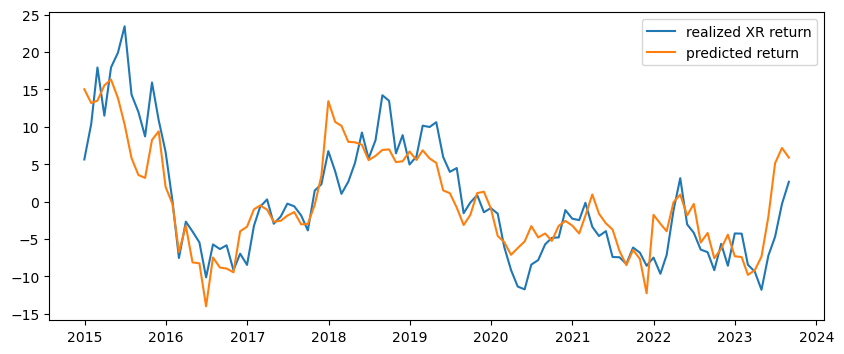

In [141]:
plt.plot(Y, label = 'realized XR return') 
plt.plot(Y.index, results.predict(), label='predicted return') 
plt.legend()
plt.show()

### 환율 예측

In [142]:
df_merged.tail(2)

,krw_jpy_xr,policy_ir_kr,policy_ir_jp,mon_base_kr,mon_base_jp,mon_broad_kr,mon_broad_jp,export_kr,export_jp,import_kr,...,stock_ratio,ipi_diff,ipi_diff_rt,unemployment_ratio,unemployment_ratio_rt,wui_kor_ravg,wui_jpn_ravg,wui_diff,irlt_usd_jpn_diff,irlt_usd_jpn_diff_rt
date,,,,,,,,,,,,,,,,,,,,,
2024-07-31,905.44,3.5,0.05,277730534.0,664558600.0,3.971094e+09,1.627906e+09,58042.0,58354.0,53187.0,...,0.767717,25.2,64.705882,1.12,4.00,0.0,0.0,0.0,3.26,-105.684431
2024-08-31,929.08,3.5,0.05,277730534.0,664558600.0,3.971094e+09,1.627906e+09,58042.0,58354.0,53187.0,...,0.767717,25.2,16.666667,1.12,16.48,0.0,0.0,0.0,3.26,-124.115981


In [152]:
last_xr = 931.09

In [153]:
last_obs = X.iloc[-1]
last_obs

const                      1.000000
mon_multiplier_diff_rt     5.223501
stock_ratio                0.864902
ir_jpn_diff_rt            63.841808
real_xr                    0.943203
ca_gdp_jp                  2.093027
infl_diff                  0.234659
reserves_to_gdp           24.989364
reserves_growth           -4.154381
Name: 2023-08-31 00:00:00, dtype: float64

In [154]:
pred_ret = results.predict(exog=last_obs)
pred_ret

None    5.887344
dtype: float64

In [156]:
pred_xr = last_xr * (1 + pred_ret[0] / 100)
pred_xr

985.9064673541766

In [150]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [151]:
for alpha in [0.05, 0.25, 0.50]:
    prstd, iv_l, iv_u = \
        wls_prediction_std(results, exog=last_obs, alpha=alpha)
    
    print("Confidence Interval at alpha={:.2f}: {:.2f} ~ {:.2f}".format(
        alpha,
        last_xr * (1 + iv_l[0] / 100),
        last_xr * (1 + iv_u[0] / 100),
    ))

Confidence Interval at alpha=0.05: 899.78 ~ 1067.78
Confidence Interval at alpha=0.25: 934.80 ~ 1032.76
Confidence Interval at alpha=0.50: 955.13 ~ 1012.43
